In [1]:
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
from model import GPT
from evals import grammar_evals
from dgp import get_dataloader
import os
import pickle as pkl
import json
from sae import SAEData, SAE
import matplotlib.pyplot as plt
import random
import seaborn as sns
import matplotlib
import math
from math import ceil
from tqdm import tqdm

# Load Model, Config, Data

In [2]:
path = 'results/scratch/3v4gwdfk' #['3v4gwdfk', 'vx8j11gp', '9rts35mx']
state_dict = torch.load(os.path.join(path, 'latest_ckpt.pt'), map_location='cpu')
cfg = state_dict['config']

/var/folders/7s/t502n_qs6zg3d8hynhr0prpm0000gn/T/ipykernel_24467/2877519087.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(os.path.join(path, 'l

In [3]:
with open(os.path.join(path, 'grammar/PCFG.pkl'), 'rb') as f:
    pcfg = pkl.load(f)
model = GPT(cfg.model, pcfg.vocab_size)
model.load_state_dict(state_dict['net'])
model.eval()
dataloader = get_dataloader(
        language=cfg.data.language,
        config=cfg.data.config,
        alpha=cfg.data.alpha,
        prior_type=cfg.data.prior_type,
        num_iters=cfg.data.num_iters * cfg.data.batch_size,
        max_sample_length=cfg.data.max_sample_length,
        seed=cfg.seed,
        batch_size=cfg.data.batch_size,
        num_workers=0,
    )

In [4]:
layer_name = 'res0'
data = SAEData(model_dir=path, ckpt='latest_ckpt.pt', layer_name=layer_name, config=False, device='cpu')

# If old
production_rules = """
        S -> NP VP [1.0] | VP NP [0.0] 
        NP -> Adj N [0.5] | NP Conj NP [0.25] | Pro [0.25]
        VP -> V [0.25] | V NP [0.35] | VP Adv [0.25] | VP Conj VP [0.15] 
        """
from dgp.PCFG import ProbabilisticGenerator
data.dataset.PCFG.grammar =  ProbabilisticGenerator.fromstring(production_rules + data.dataset.PCFG.lexical_symbolic_rules)
#####

match layer_name:
    case "wte":   module = model.transformer.wte
    case "wpe":   module = model.transformer.wpe
    case "attn0": module = model.transformer.h[0].attn
    case "mlp0":  module = model.transformer.h[0].mlp
    case "res0":  module = model.transformer.h[0]
    case "attn1": module = model.transformer.h[1].attn
    case "mlp1":  module = model.transformer.h[1].mlp
    case "res1":  module = model.transformer.h[1]
    case "ln_f":  module = model.transformer.ln_f

Loading model...
Model loaded.


/Users/abhinavmenon/Desktop/Cambridge/pcfg-sae-causal/sae/data.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = torch.load(os.path.join(self.model_dir, self

# Analysing Trained SAEs

In [5]:
def get_sae(idx):
    embedding_size = data[0][0].size(-1)
    args = json.load(open(os.path.join(path, f'sae_{idx}/config.json')))
    sae = SAE(embedding_size, args['exp_factor'] * embedding_size, k=args['k'], sparsemax=args['sparsemax'] if 'sparsemax' in args.keys() else False, pre_bias=args['pre_bias'] if 'pre_bias' in args.keys() else False, norm=args['norm'] if 'norm' in args.keys() else "")
    state_dict = torch.load(os.path.join(path, f'sae_{idx}/model.pth'), map_location='cpu')
    sae.load_state_dict(state_dict)
    sae.eval()
    return sae

def get_config(idx):
    return json.load(open(os.path.join(path, F'sae_{idx}/config.json')))

## Examining Features

What is the distribution of latent features?

In [6]:
def get_latents_and_sequences(sae, num_sequences=128):
    latents = []
    sequences = []
    dec = dataloader.dataset.decorator_length
    pcfg = dataloader.dataset.PCFG
    pad = pcfg.vocab['<pad>']
    eos = pcfg.vocab['<eos>']

    for _ in range(num_sequences):
        activn, grad, seq = data[0]
        latent, _ = sae(activn)
        latents.append(latent.detach())
        sequences.append([c for c in seq.tolist() if c not in [pad, eos]][dec:])

    latents = torch.cat(latents, dim=0)
    return latents, sequences


/var/folders/7s/t502n_qs6zg3d8hynhr0prpm0000gn/T/ipykernel_24467/204000903.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(os.path.join(path, f's

(array([2.6027e+05, 3.2730e+03, 1.5570e+03, 1.5240e+03, 1.2290e+03,
        1.0680e+03, 1.1590e+03, 9.8800e+02, 2.8500e+02, 7.0000e+00]),
 array([  0.        ,  70.73726654, 141.47453308, 212.21179199,
        282.94906616, 353.68634033, 424.42358398, 495.16085815,
        565.89813232, 636.63537598, 707.37268066]),
 <BarContainer object of 10 artists>)

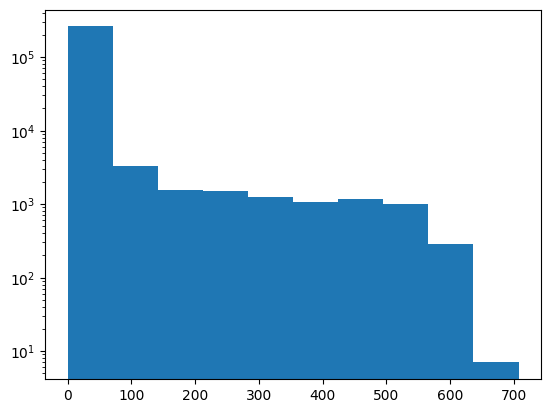

In [7]:
sae = get_sae(0)
latents, sequences = get_latents_and_sequences(sae, num_sequences=128)
plt.yscale('log')
plt.hist(latents.flatten().numpy(), bins=10)

### Token-wise Activations
What tokens do the features activate on?

In [8]:
latents_by_sequence = []
temp = latents.clone()
for sequence in sequences:
    latents_by_sequence.append(temp[:len(sequence)])
    temp = temp[len(sequence):]

In [9]:
def get_depths(tokens, pcfg, retain_all=False):
    """
    Returns the depth of the token at idx in the sentence.
    If retain_all is True, we return the depths of intermediate nonterminals also (along with the string).
    """
    parsed = str(next(pcfg.parser.parse(tokens))).split()[:-1]
    token_indices = []
    idx = 0
    for i, p in enumerate(parsed):
        if p.replace('(', '').replace(')', '') == tokens[idx]:
            token_indices.append(i)
            idx += 1
        if idx == len(tokens): break
    c = 0
    depths = []
    for i, p in enumerate(parsed):
        if i in token_indices or retain_all:
            depths.append(c)
        c += p.count('(') - p.count(')')
    if retain_all:
        return depths, [p.replace('(', '').replace(')', '') for p in parsed], token_indices
    return depths

In [10]:
def plot_latents_linearly(tokens, latents, vmax, vmin, heatmap=False):
    plt.figure(figsize = (len(sequences[i])*0.7, 0.4))

    if heatmap:
        sns.heatmap(latents.unsqueeze(0),
                    annot=[tokens],
                    fmt='', linewidths=.5, vmax=vmax, vmin=vmin, cmap='rocket', xticklabels=False, yticklabels=False)
    else:
        plt.plot(latents.numpy(), marker='o')
        plt.xticks(range(len(tokens)), tokens)
        plt.ylim(vmin-((vmax-vmin)/50), vmax)

    plt.show()

def plot_latents_by_depth(tokens, latents, pcfg, vmax, vmin):
    depths, tokens, token_indices = get_depths(tokens, pcfg, retain_all=True)

    depth_hm = torch.zeros(len(tokens), max(depths)+1)
    annot = [['' for _ in range(max(depths)+1)] for _ in range(len(tokens))]
    for i, d in enumerate(depths):
        annot[i][d] = tokens[i]
        if i in token_indices:
            tidx = token_indices.index(i)
            depth_hm[i, d] = latents[tidx].item()

    annot_transpose = [['' for _ in range(len(tokens))] for _ in range(max(depths)+1)]
    for i in range(len(tokens)):
        for j in range(max(depths)+1):
            annot_transpose[max(depths)-j][i] = annot[i][j]

    #plt.rcParams.update({'font.size': 12})
    plt.figure(figsize = ((max(depths)+1)*0.9, len(tokens)*0.4))
    #plt.figure(figsize = (len(tokens)*0.9, (max(depths)+1)*0.4))
    sns.heatmap(depth_hm, annot=annot, fmt='', linewidths=.5, vmax=vmax, vmin=vmin, cmap='rocket', xticklabels=range(1, max(depths)+2), yticklabels=range(1, len(tokens)+1))
    #sns.heatmap(depth_hm.transpose(0, 1).flip((0,)), annot=annot_transpose, fmt='', linewidths=.5, vmax=vmax, vmin=vmin, cmap='rocket', xticklabels=range(1, len(tokens)+1), yticklabels=range(max(depths)+1, 0, -1))
    plt.savefig('adjectives.pdf', dpi=400)
    plt.show()

104
189
160
211


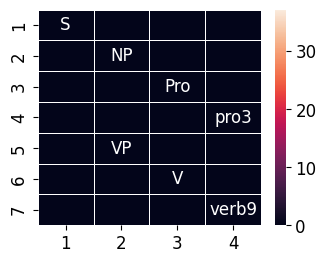

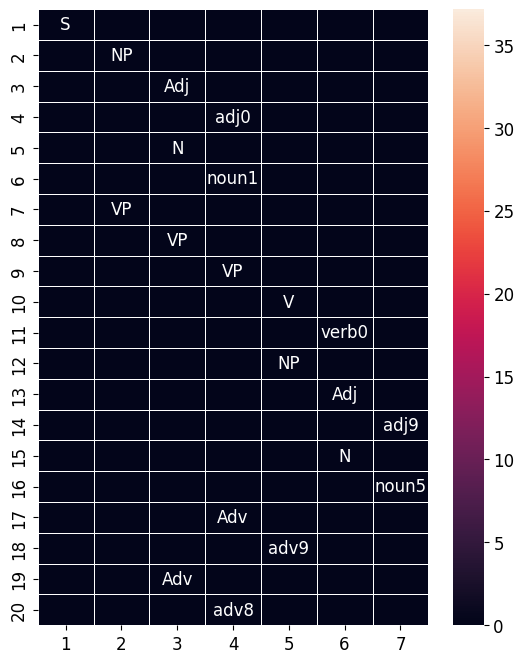

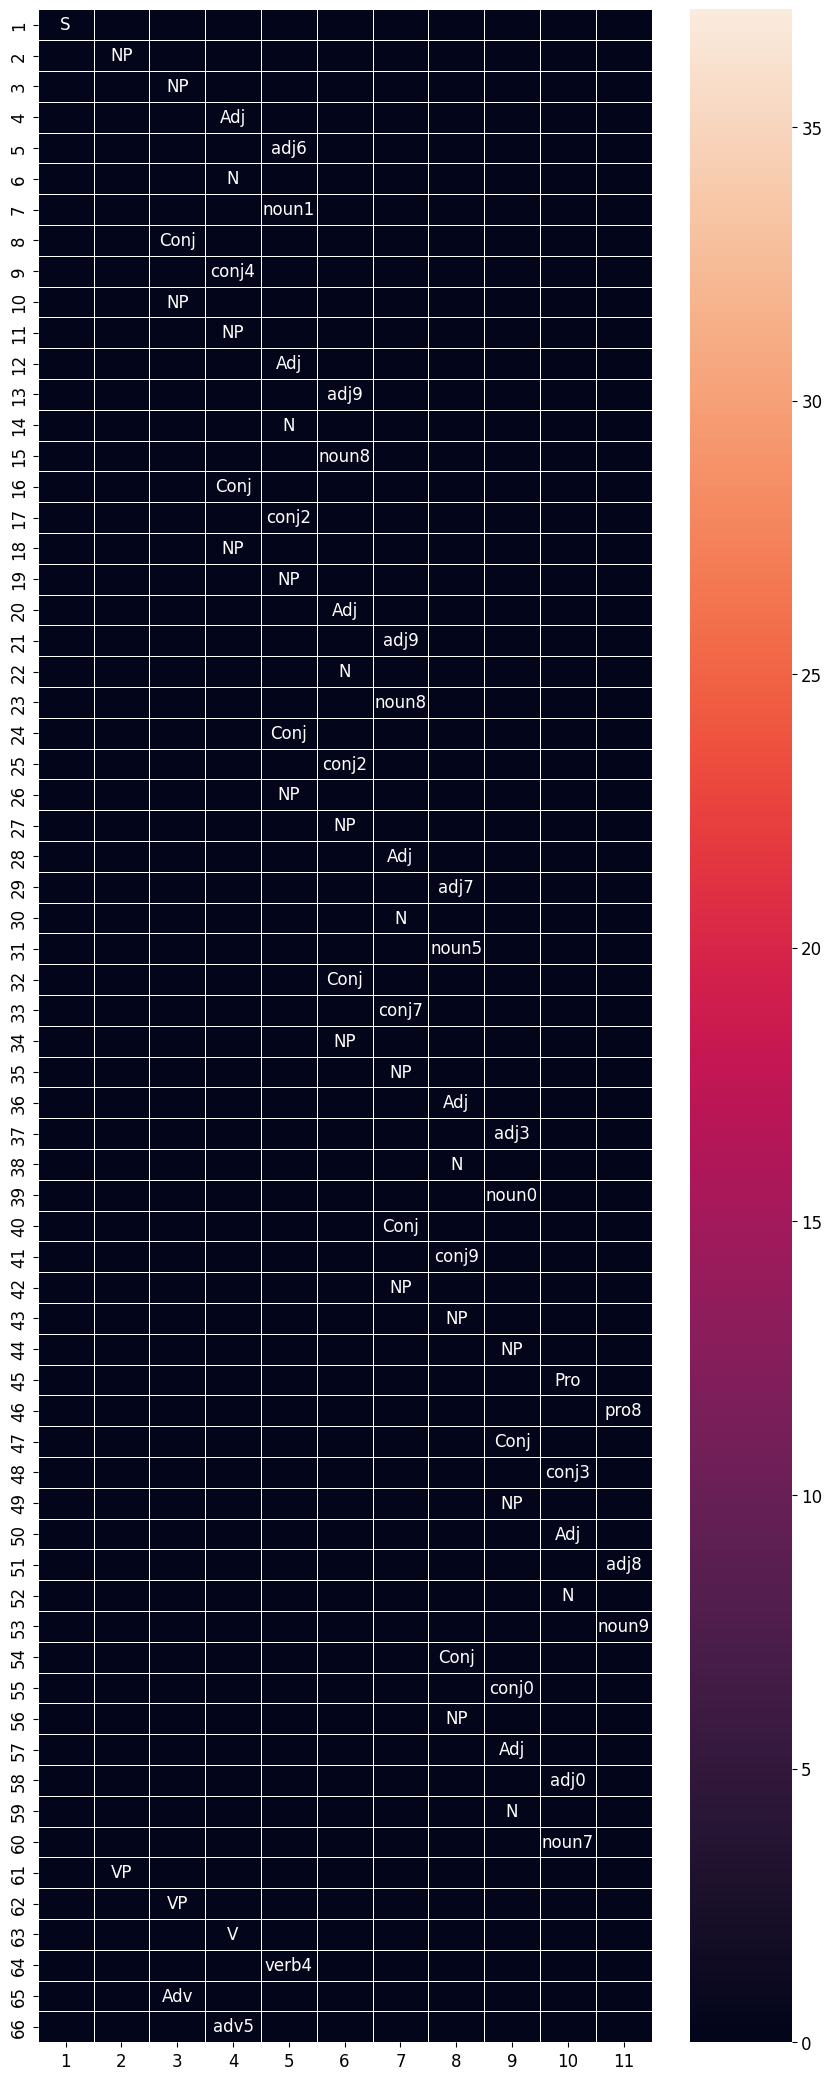

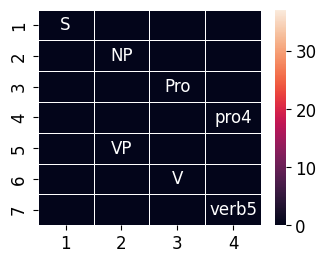

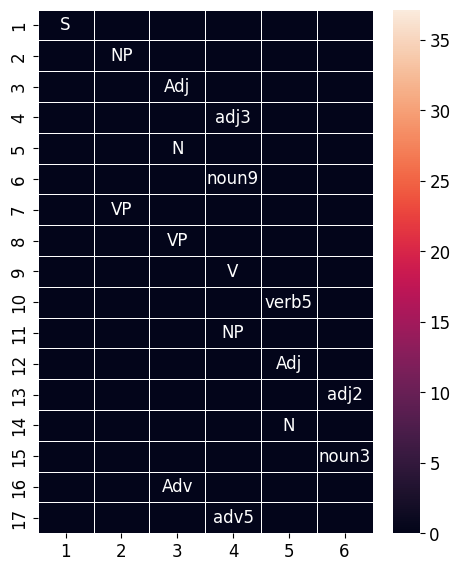

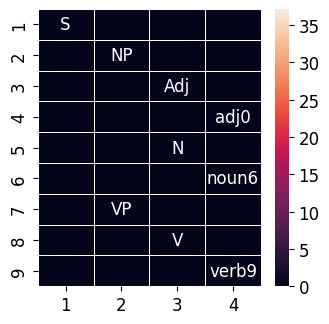

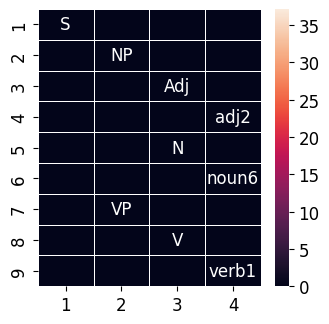

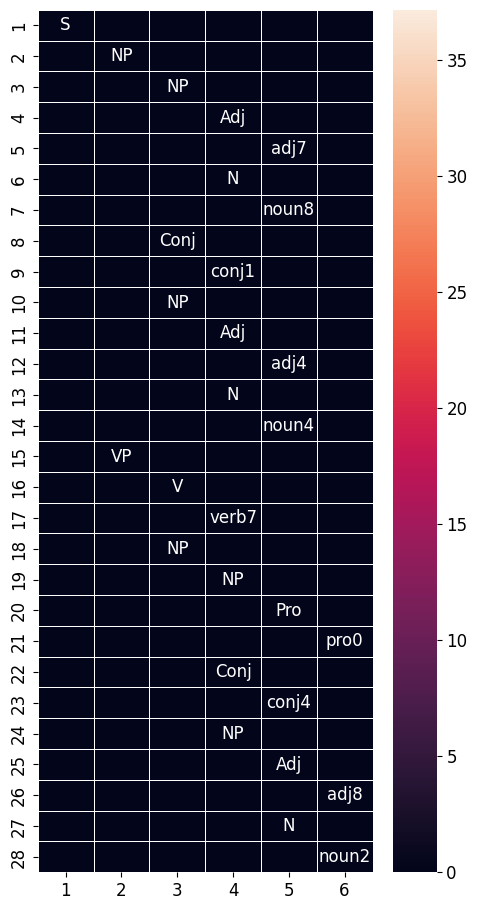

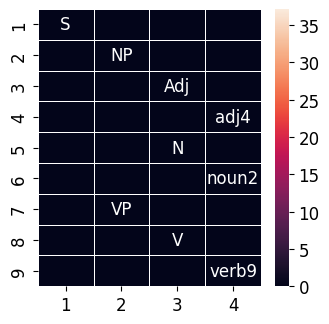

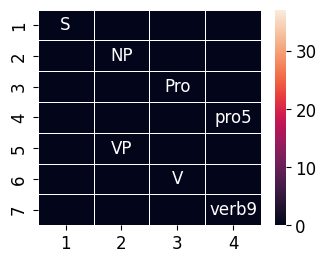

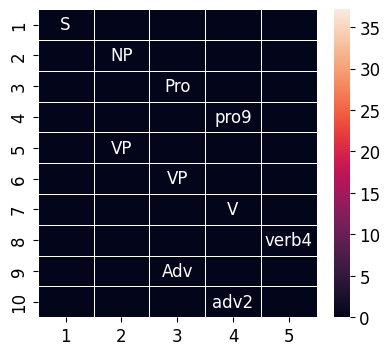

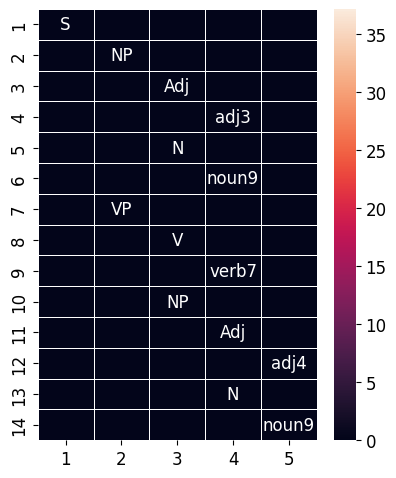

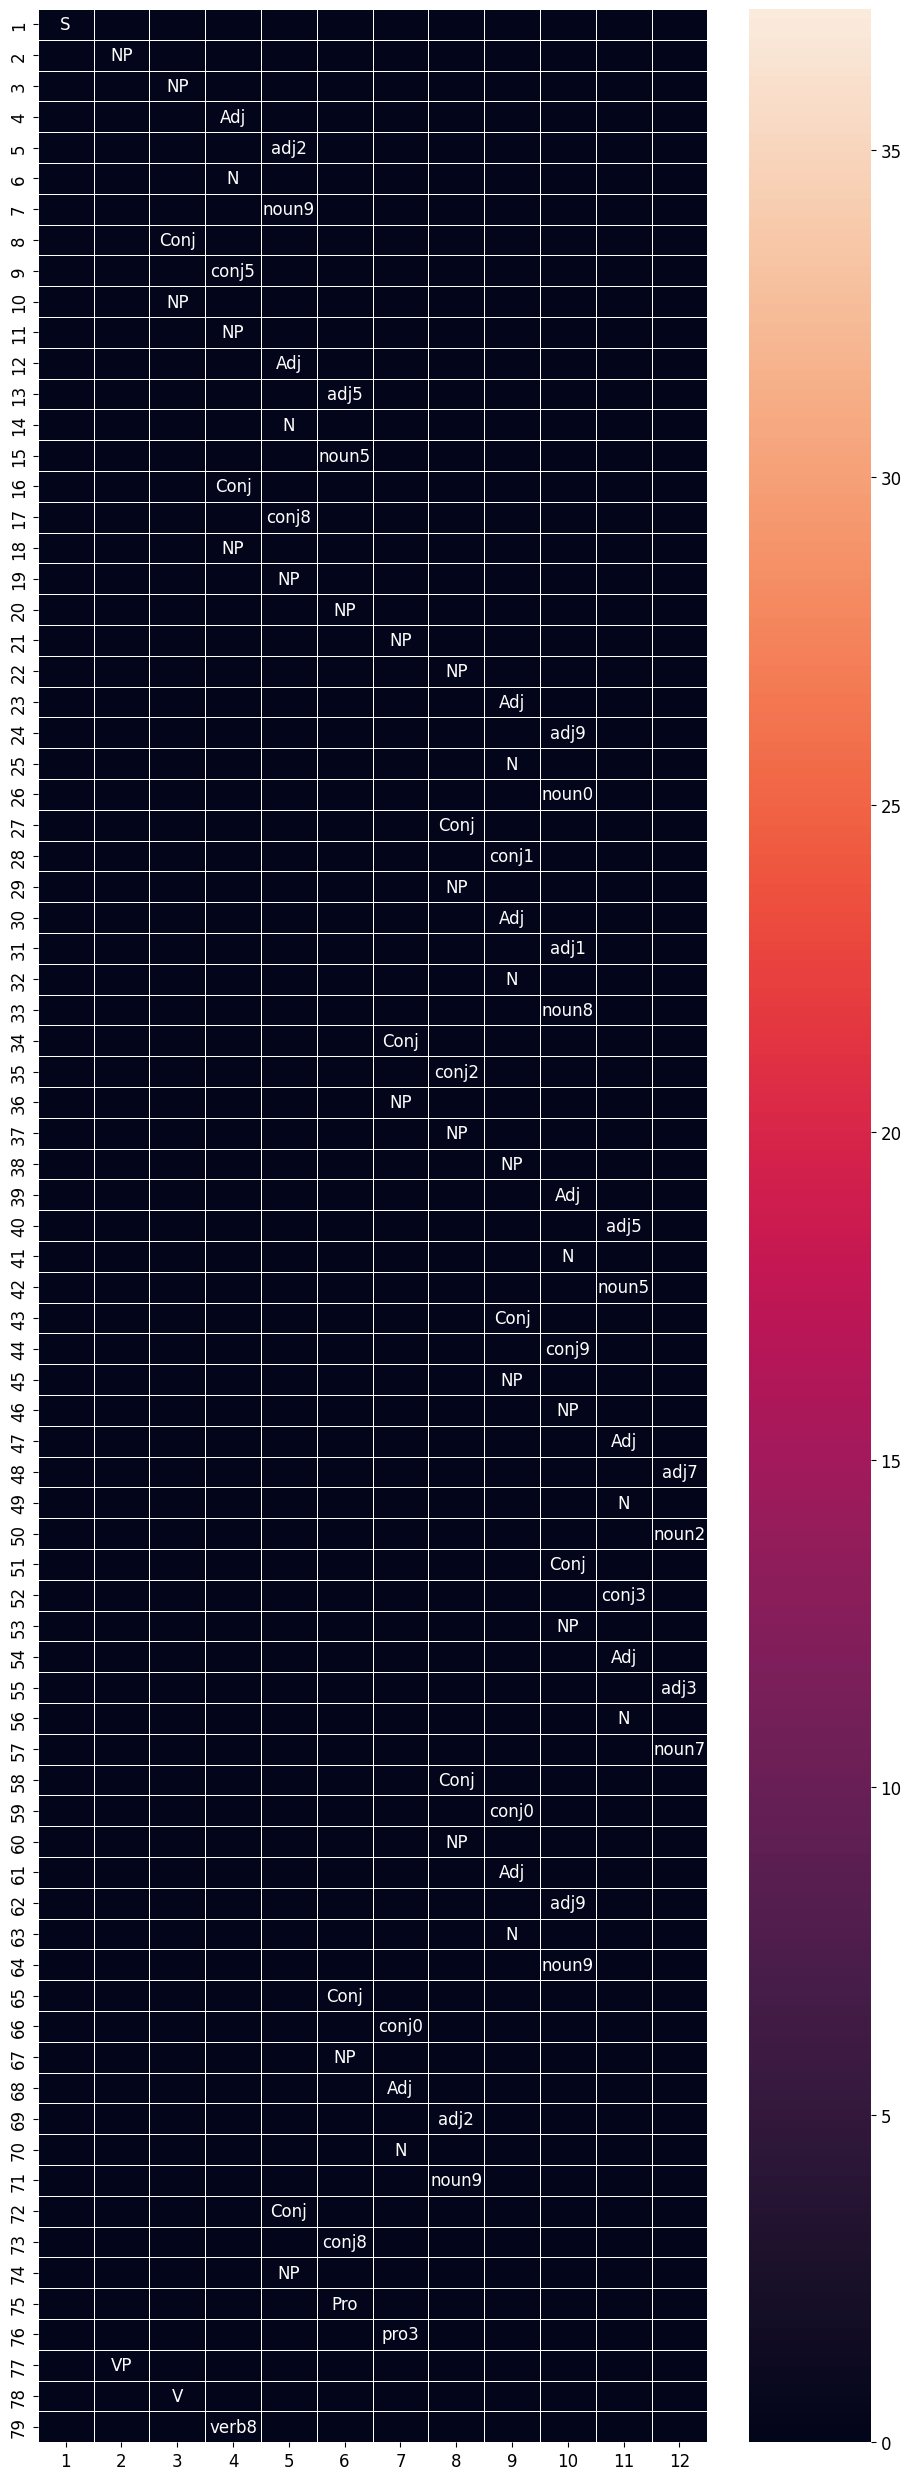

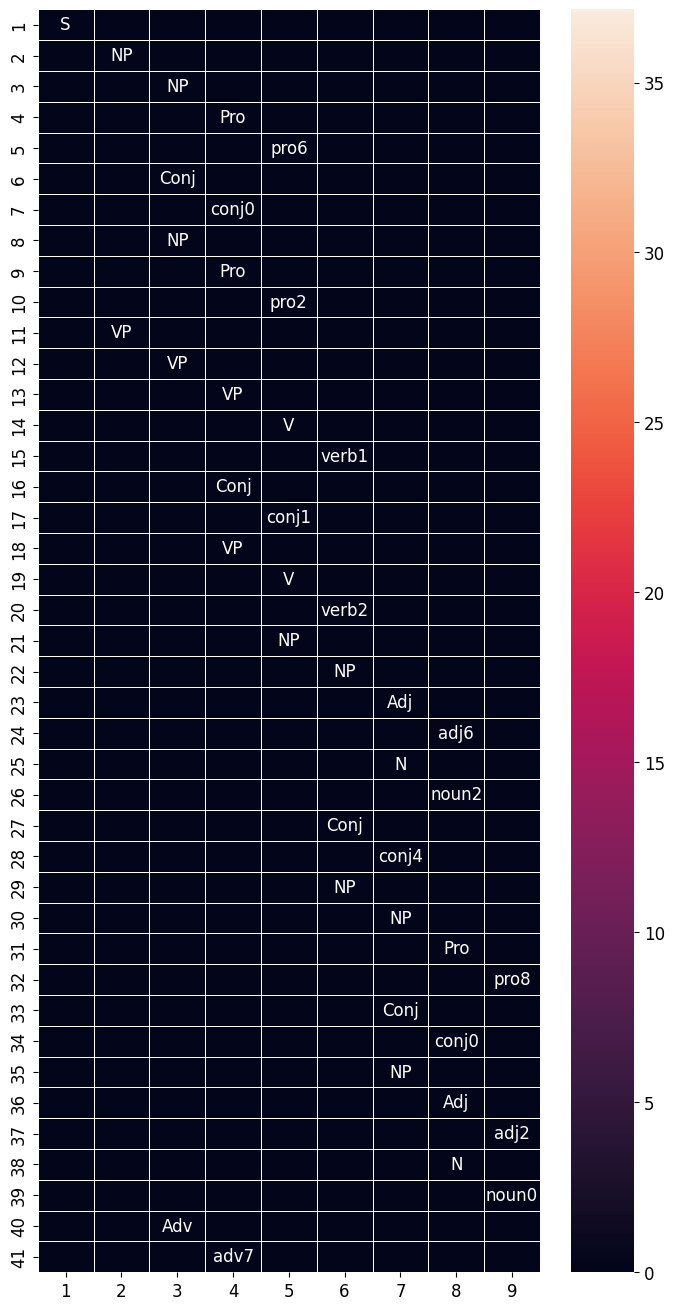

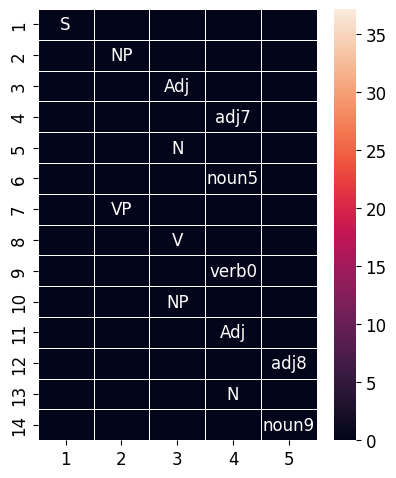

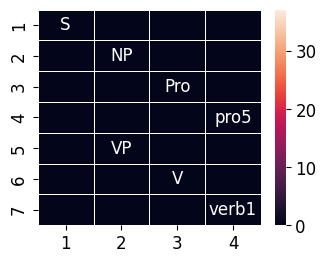

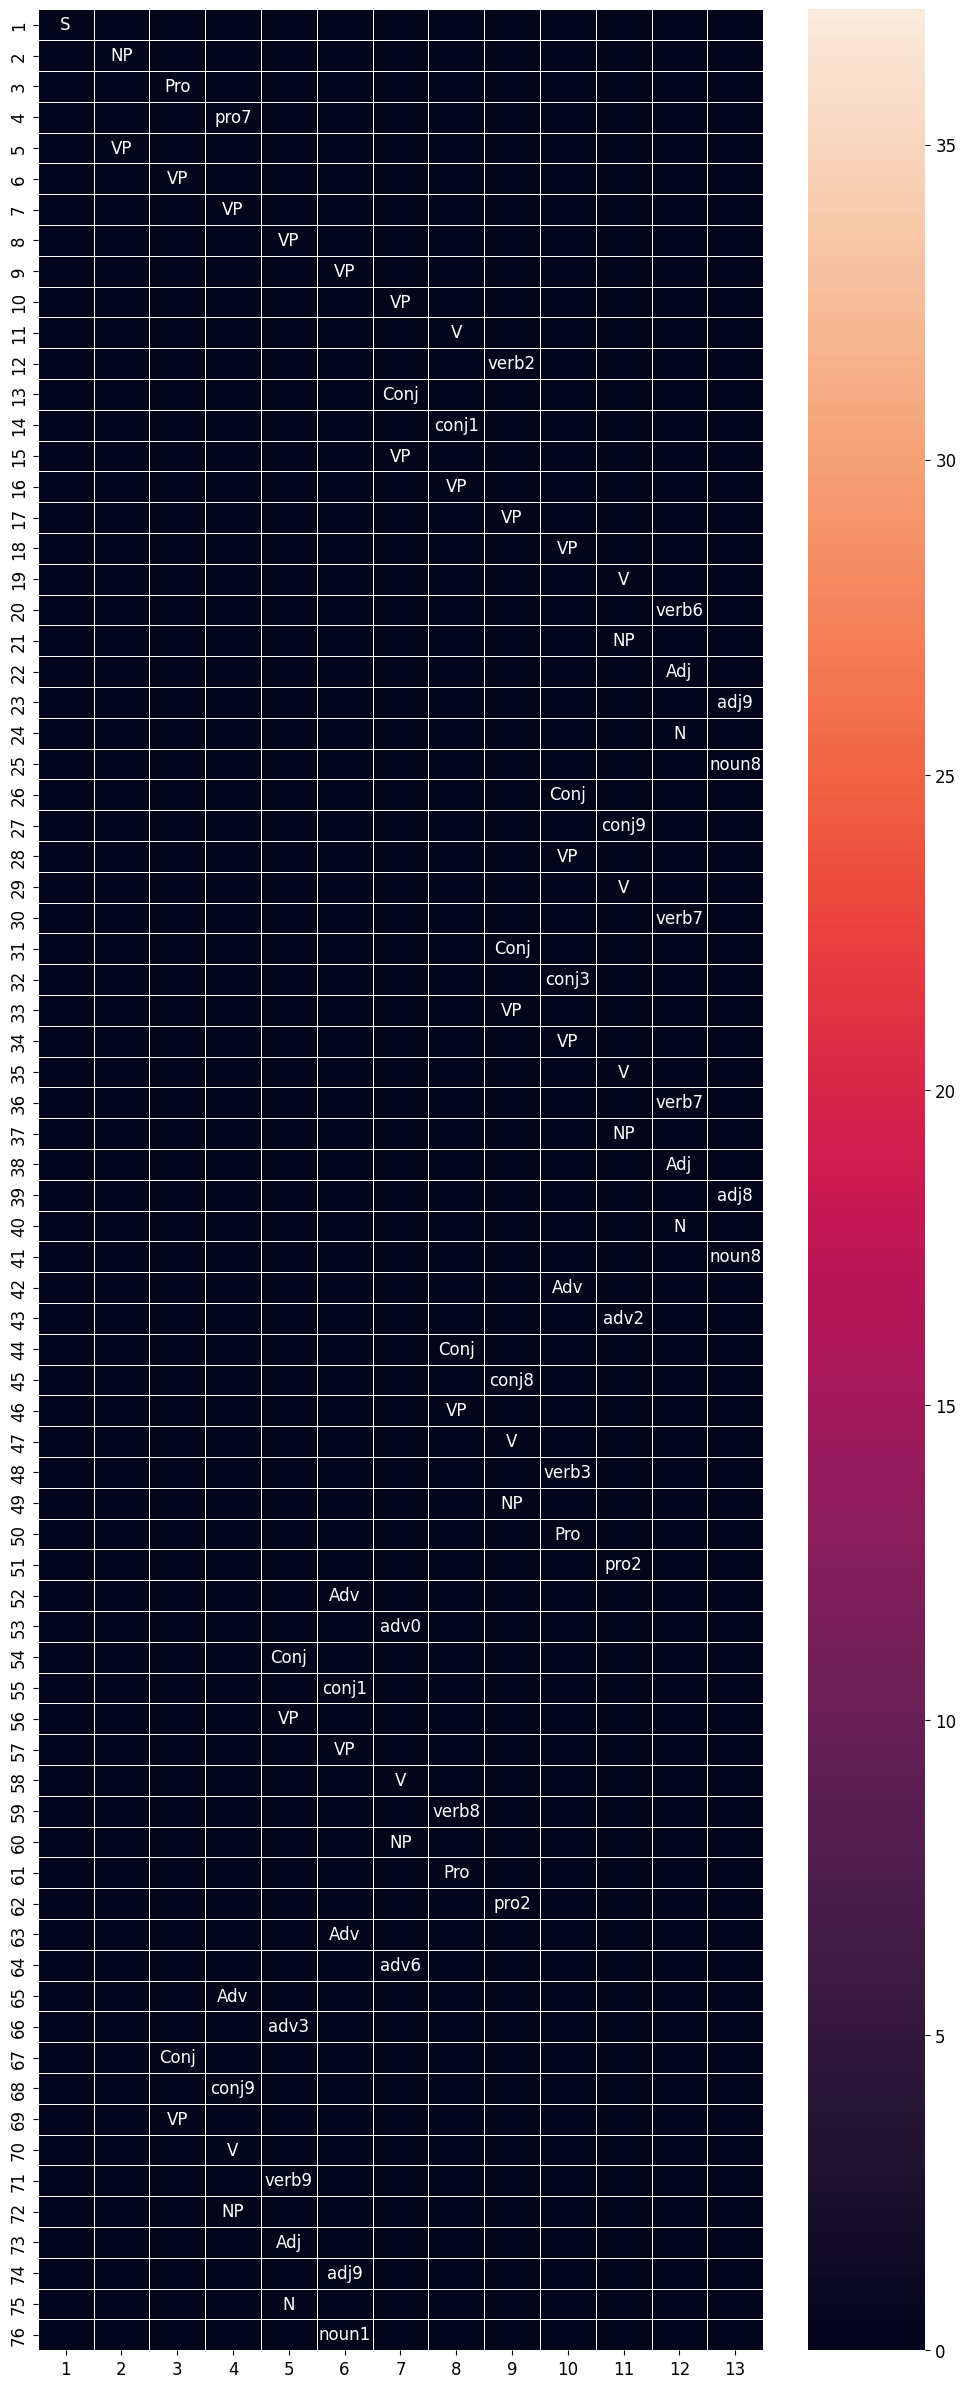

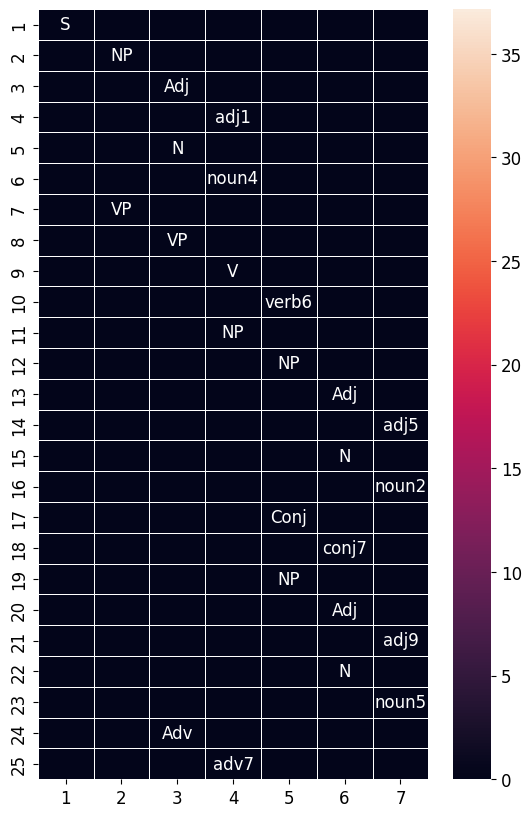

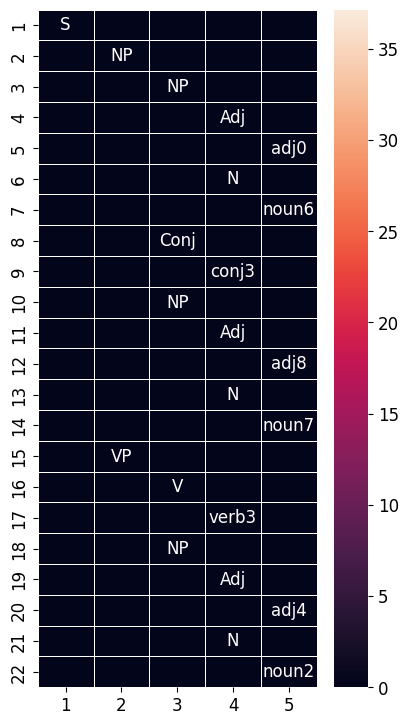

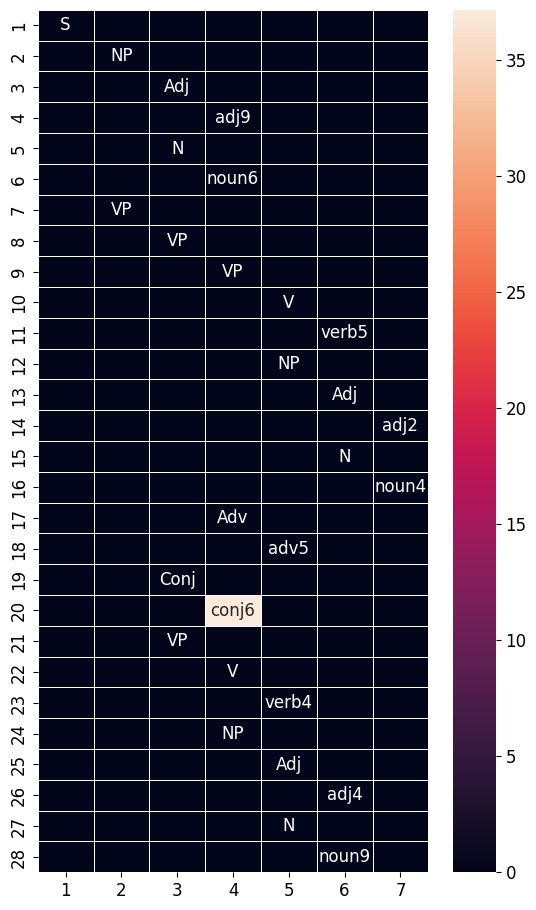

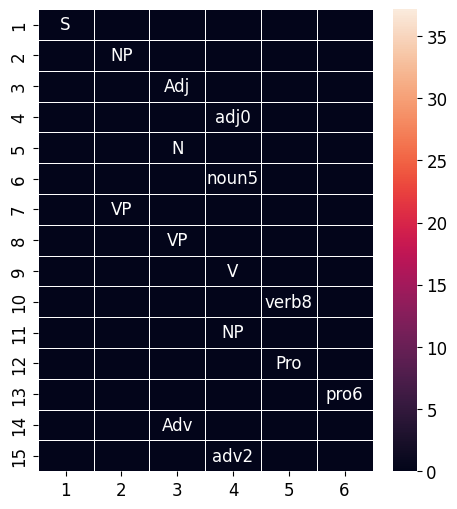

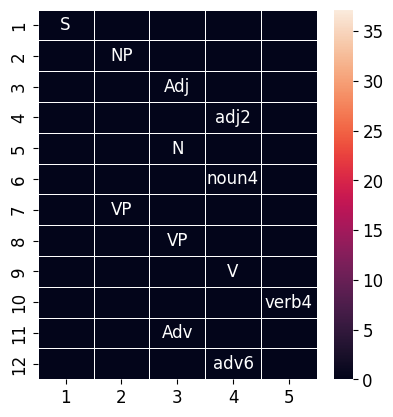

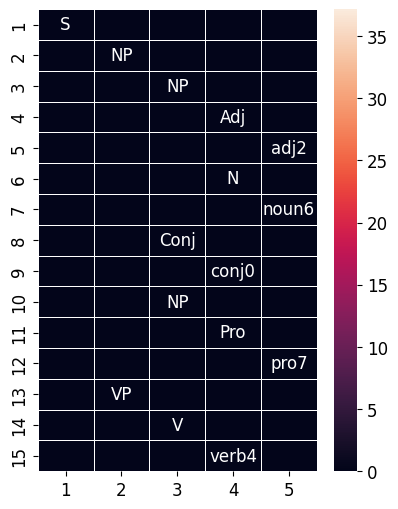

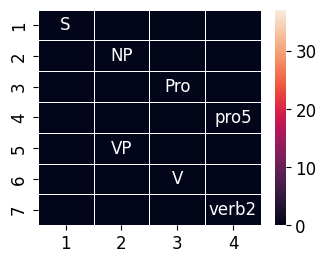

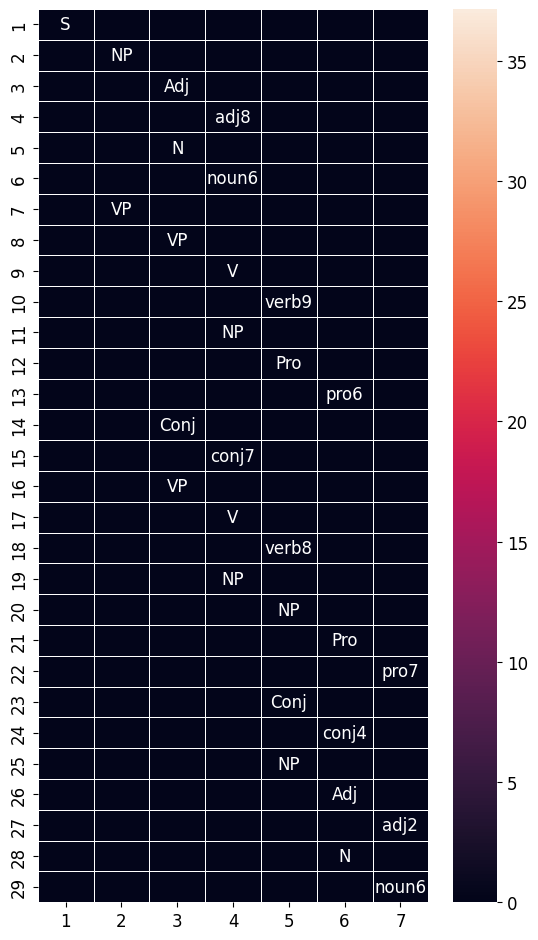

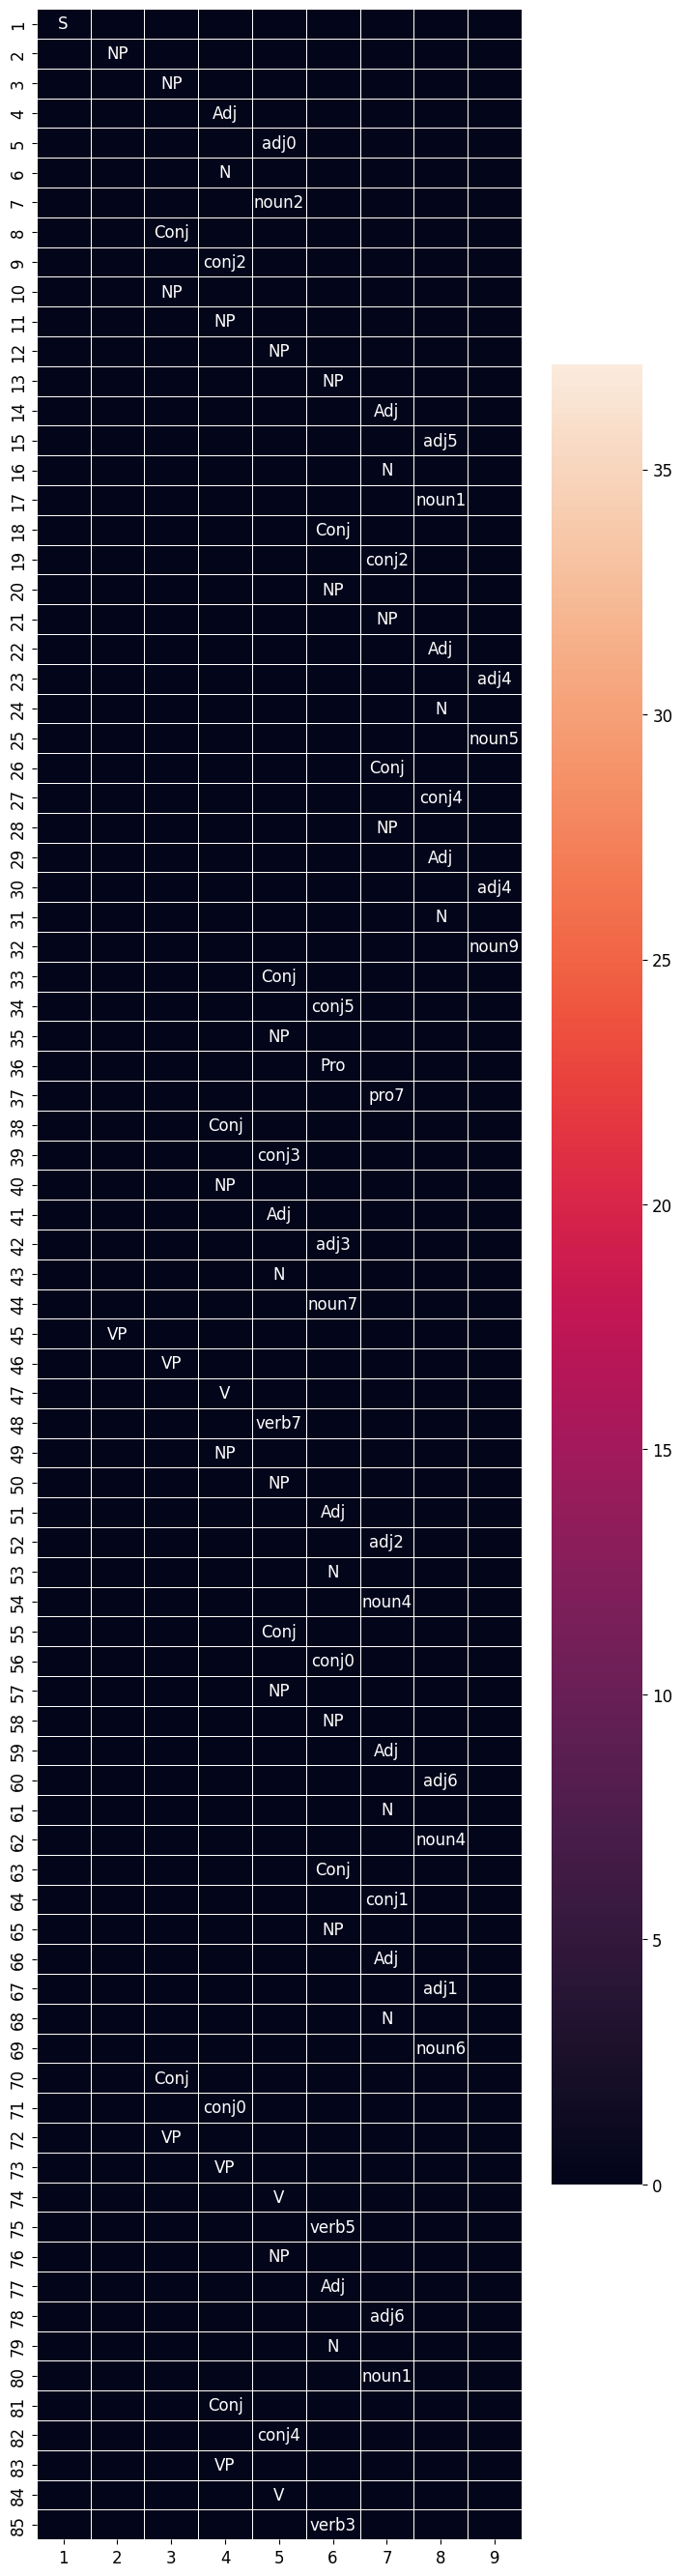

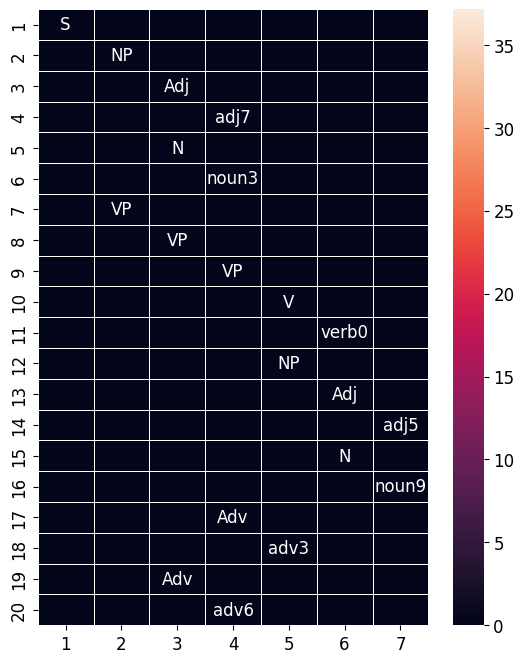

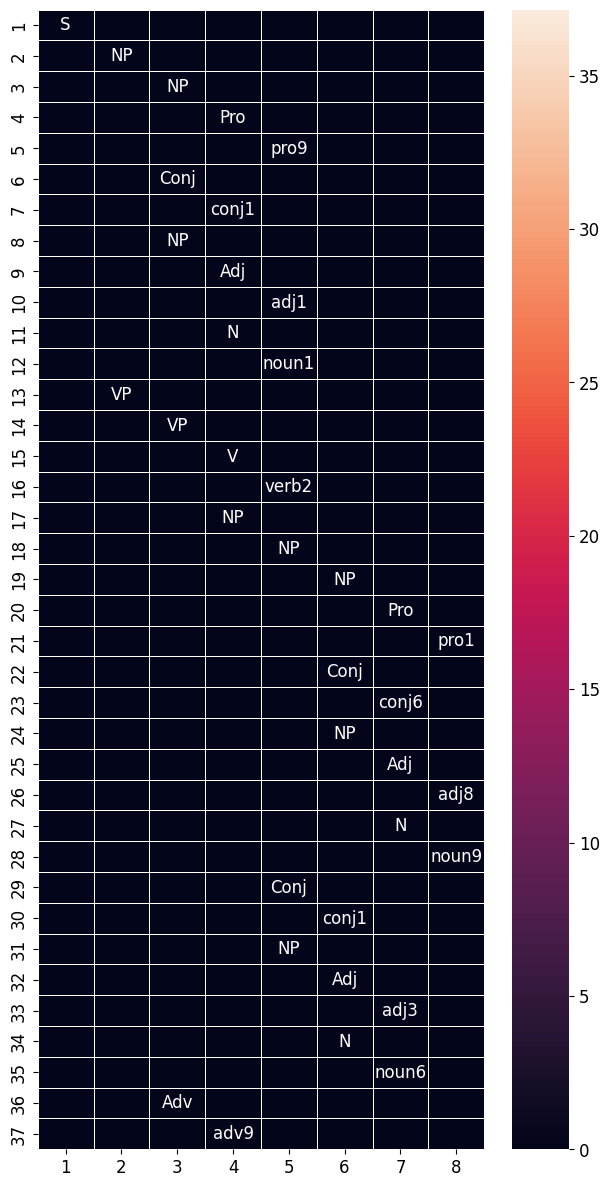

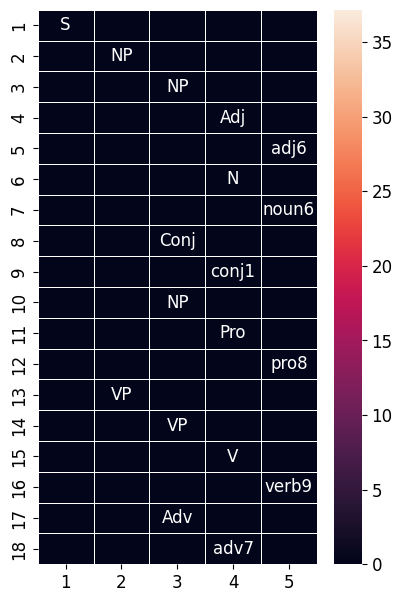

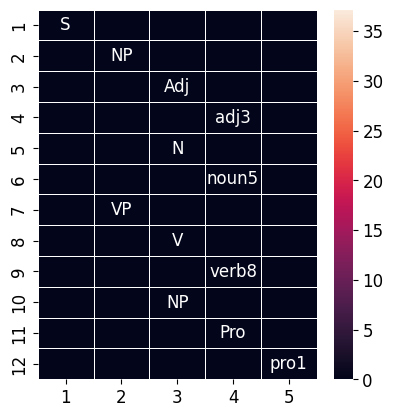

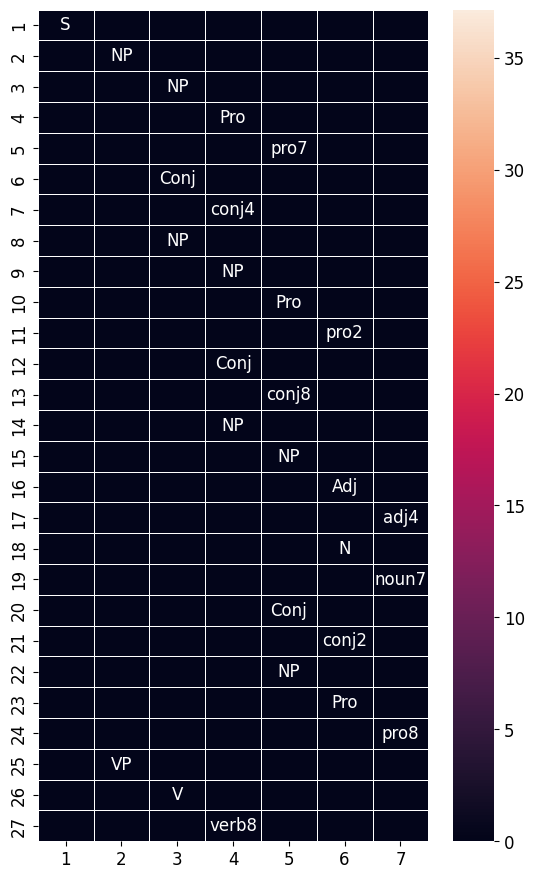

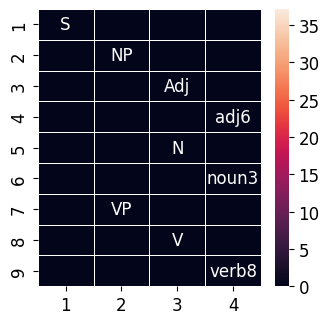

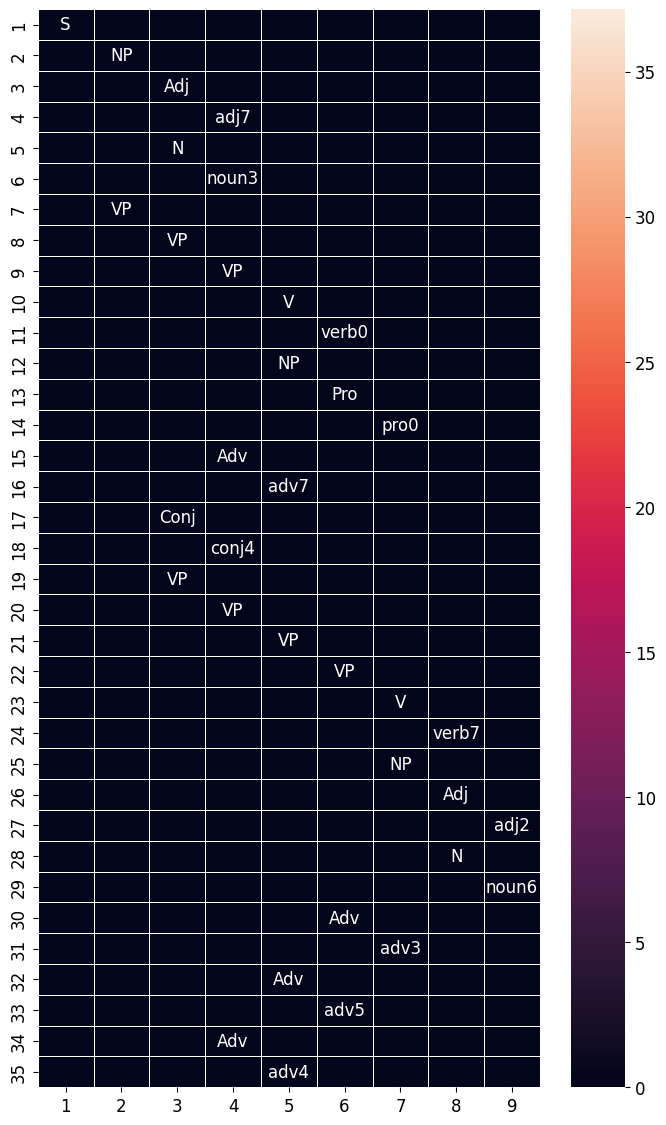

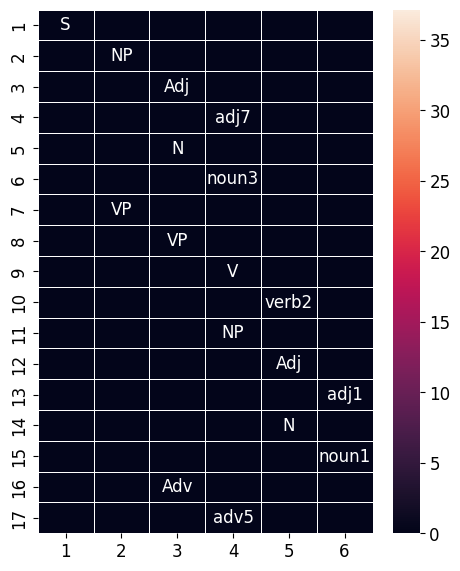

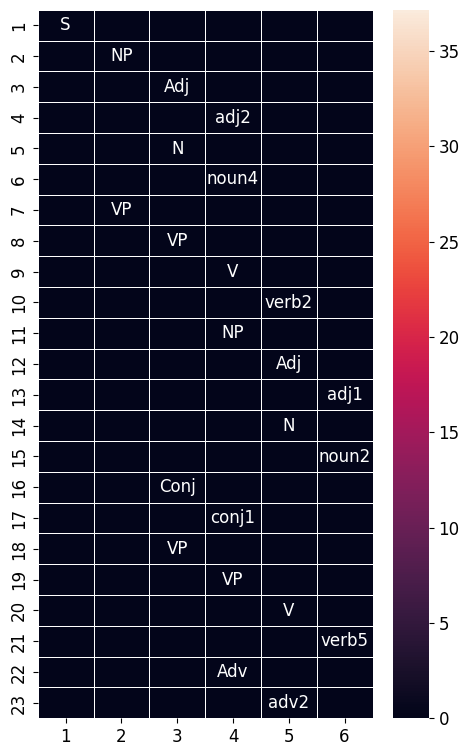

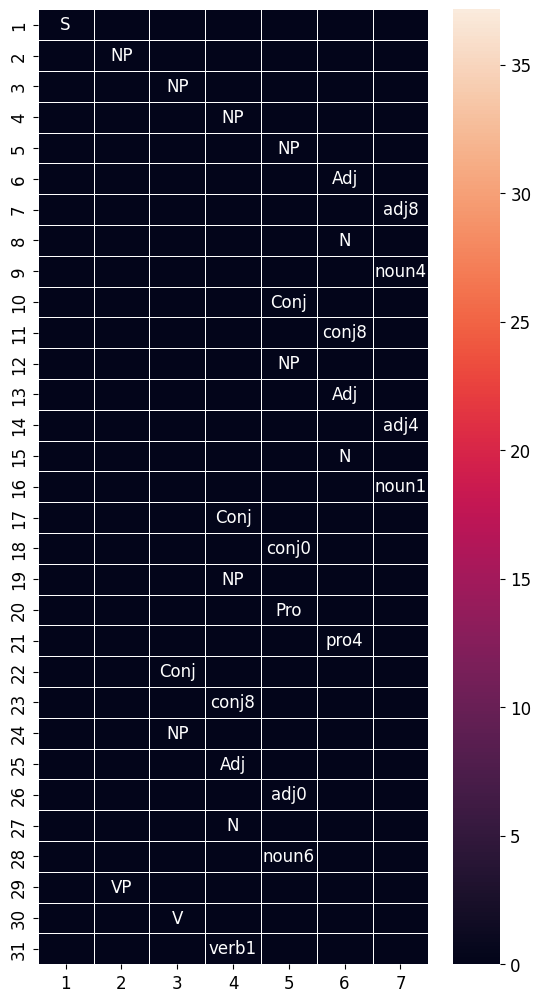

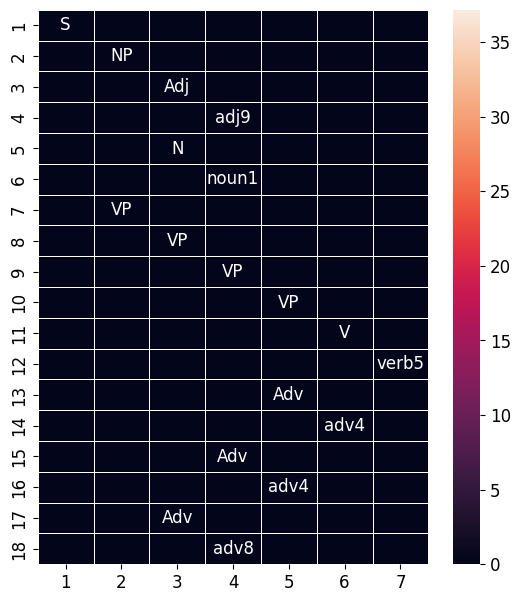

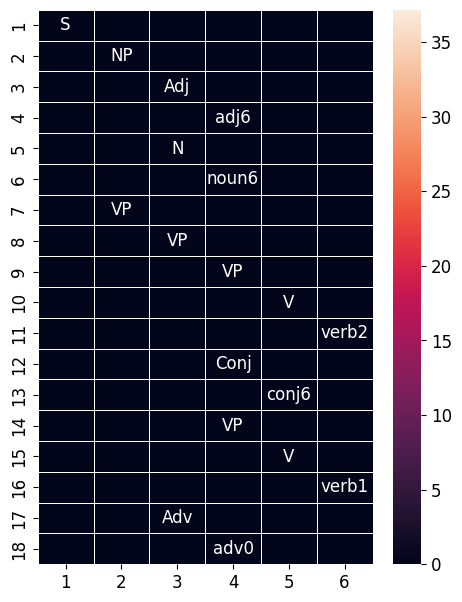

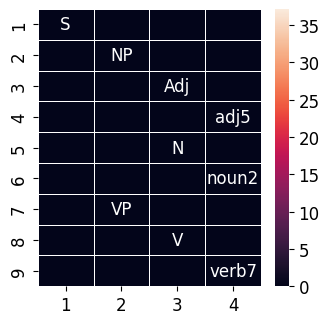

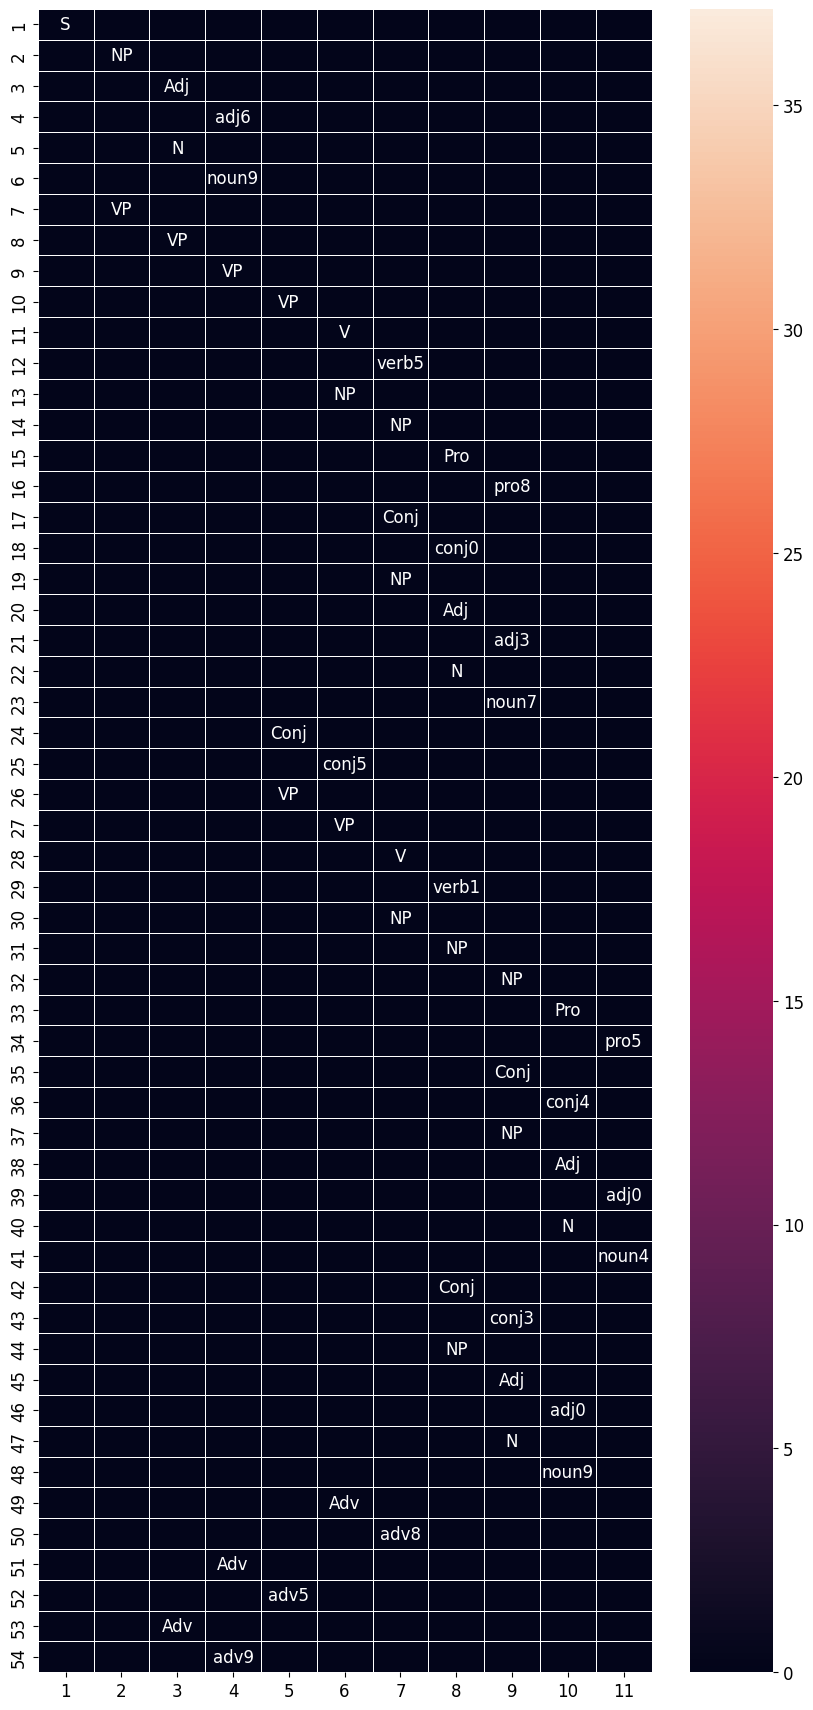

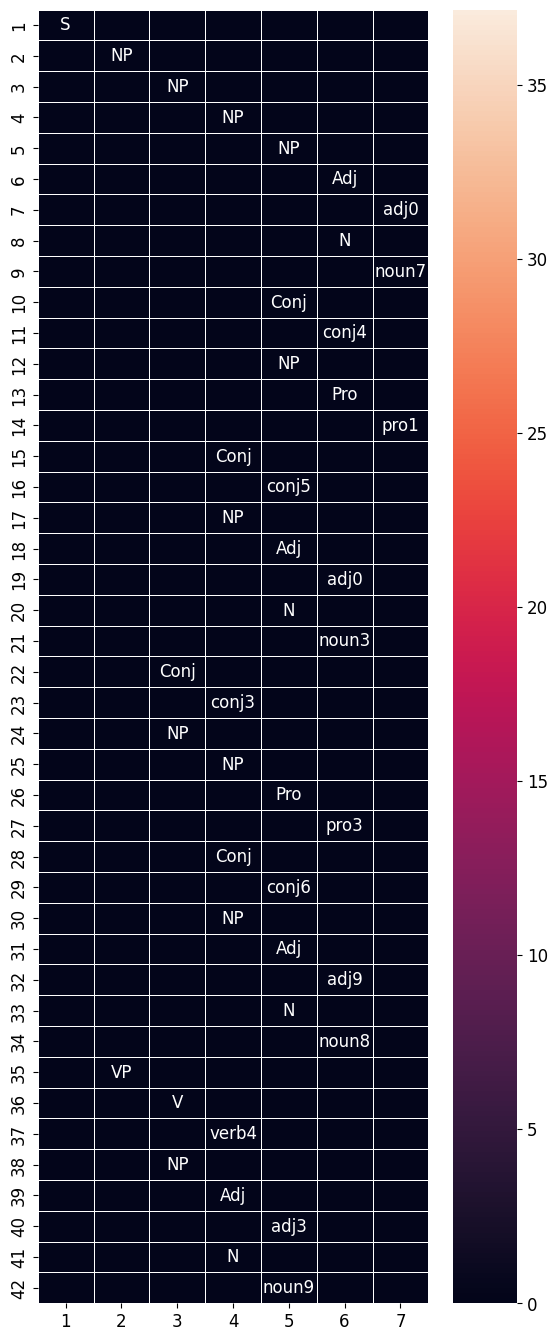

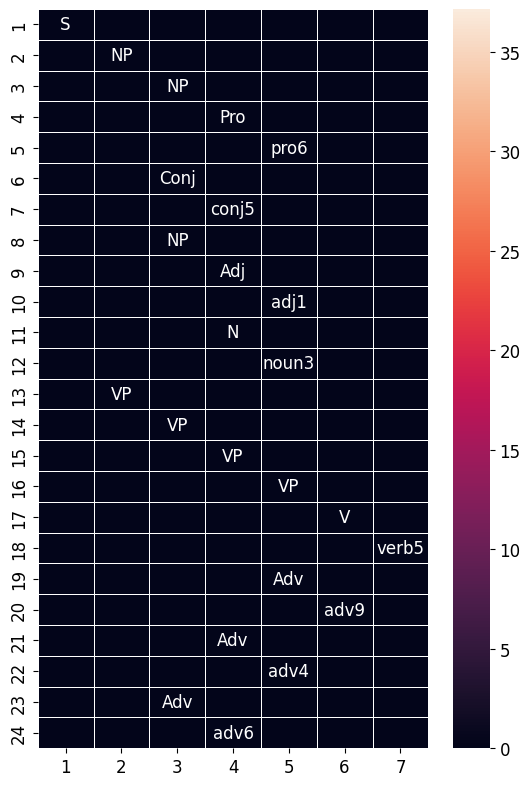

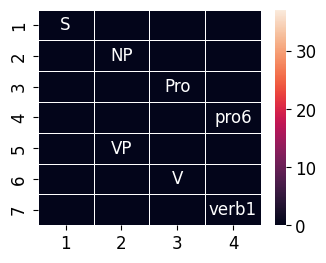

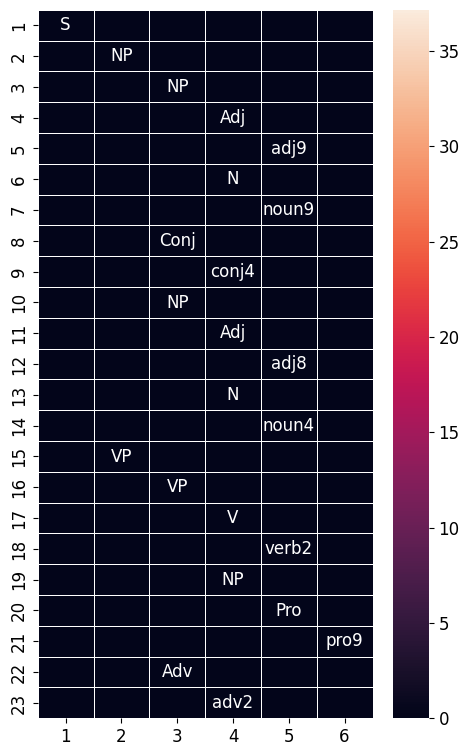

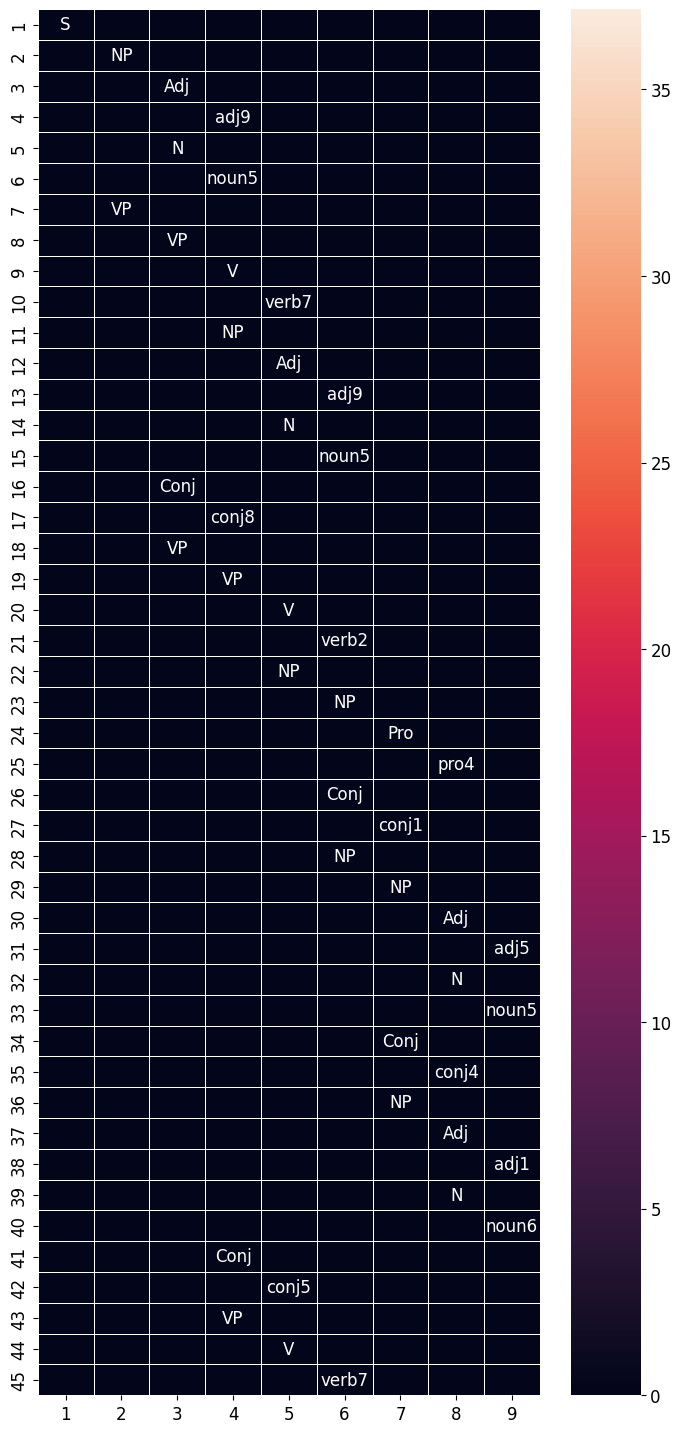

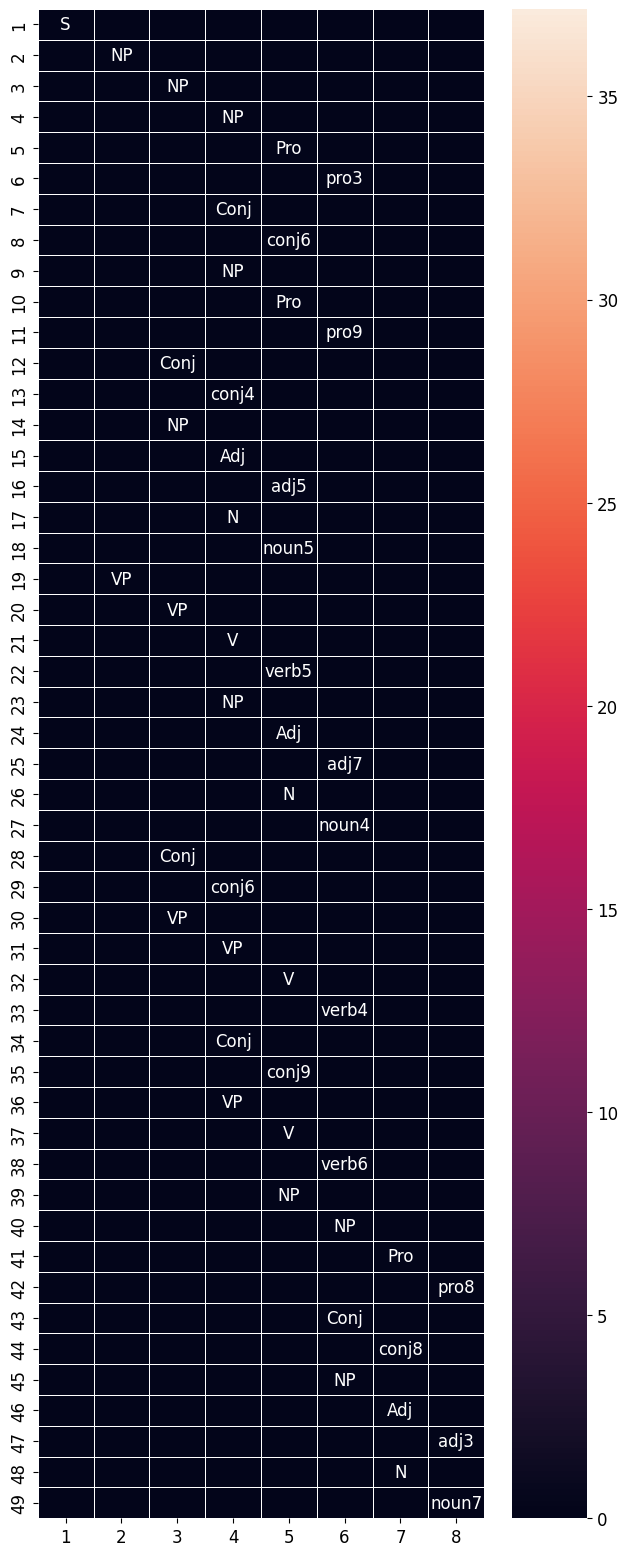

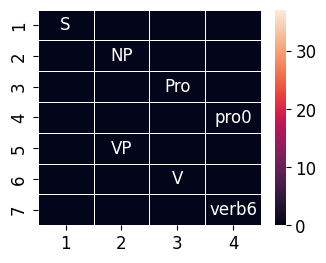

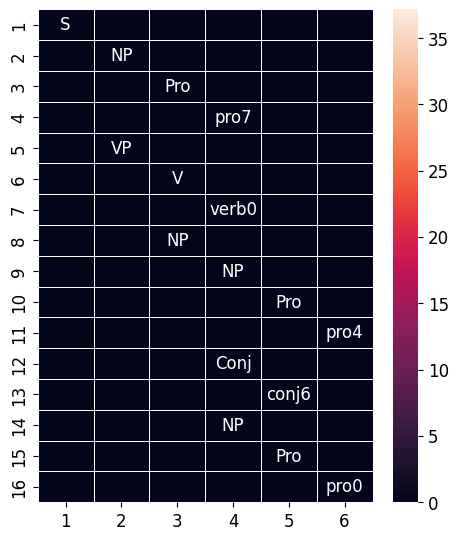

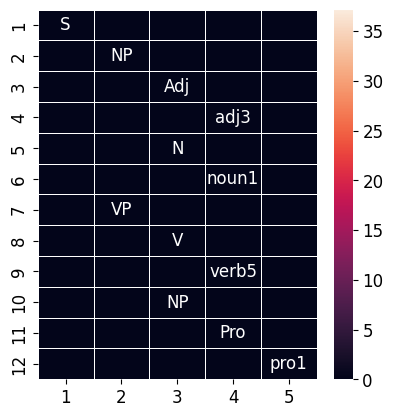

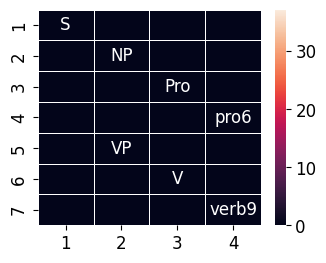

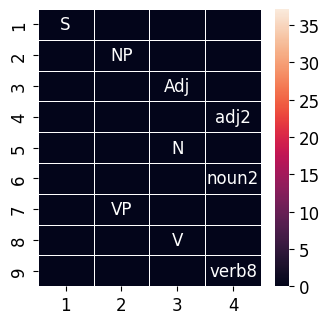

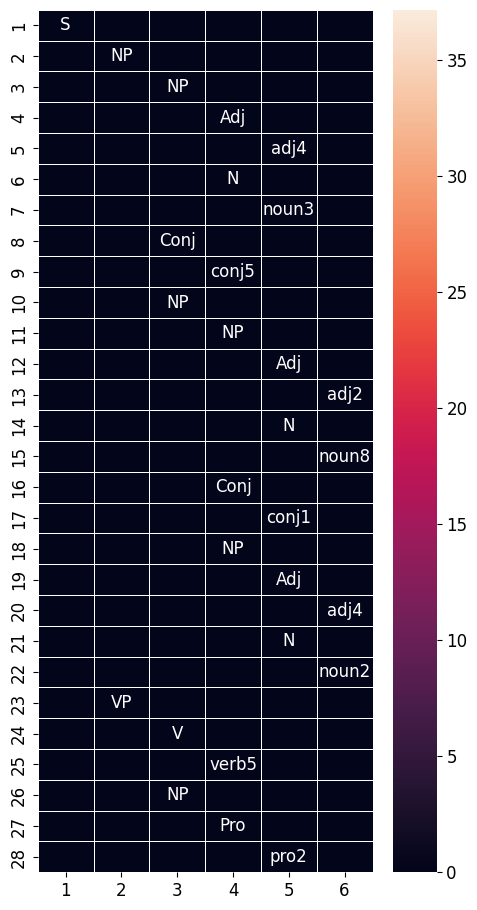

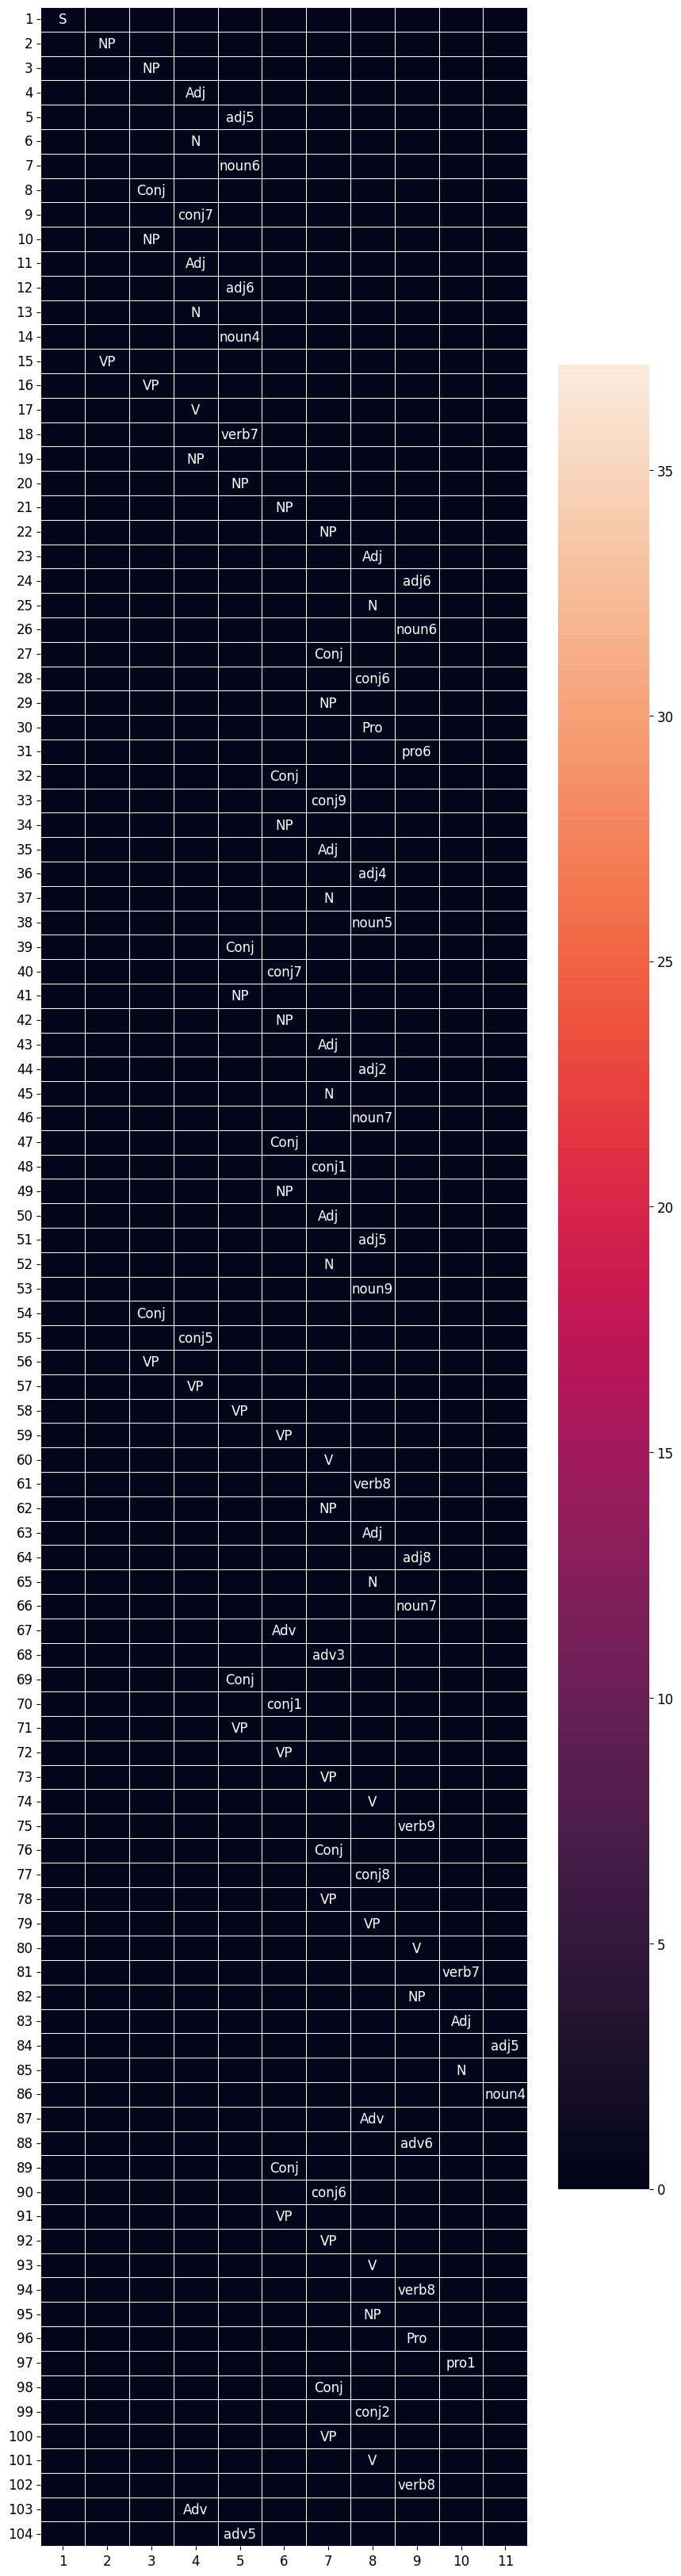

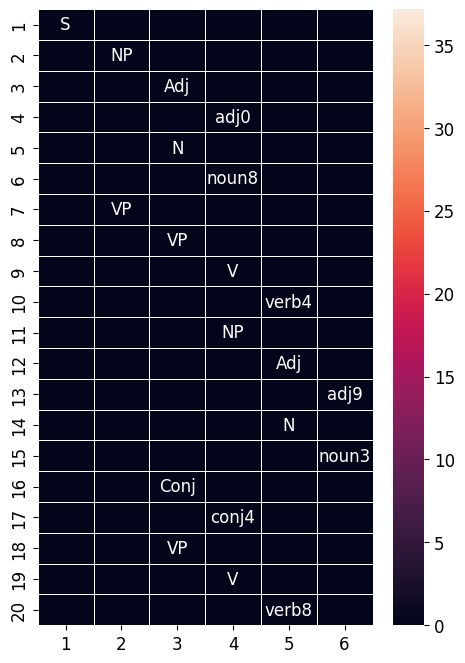

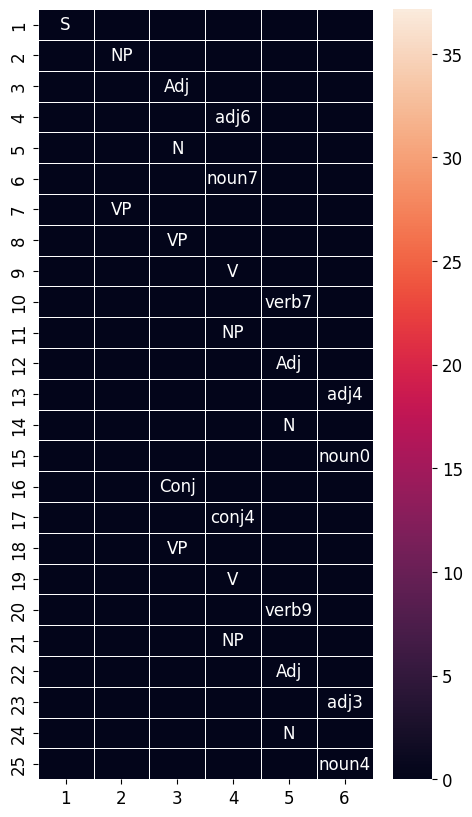

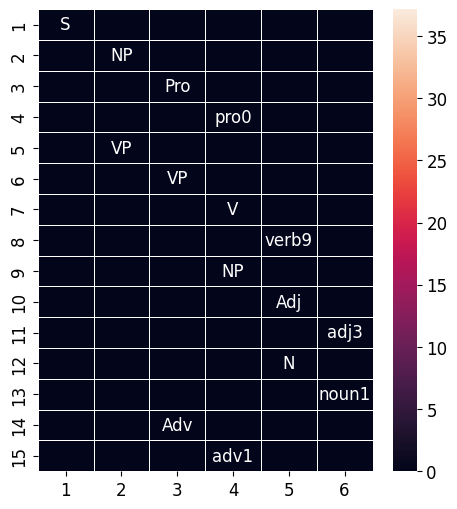

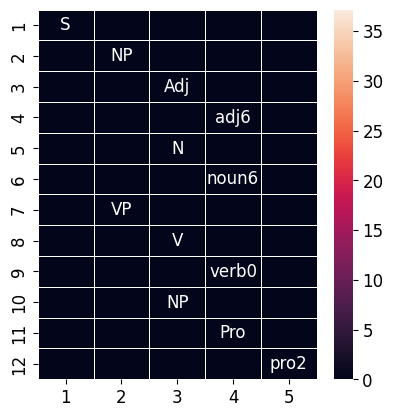

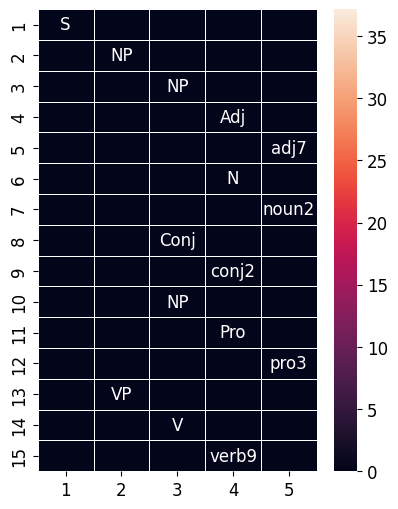

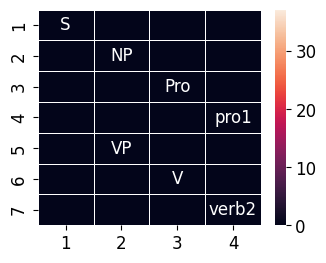

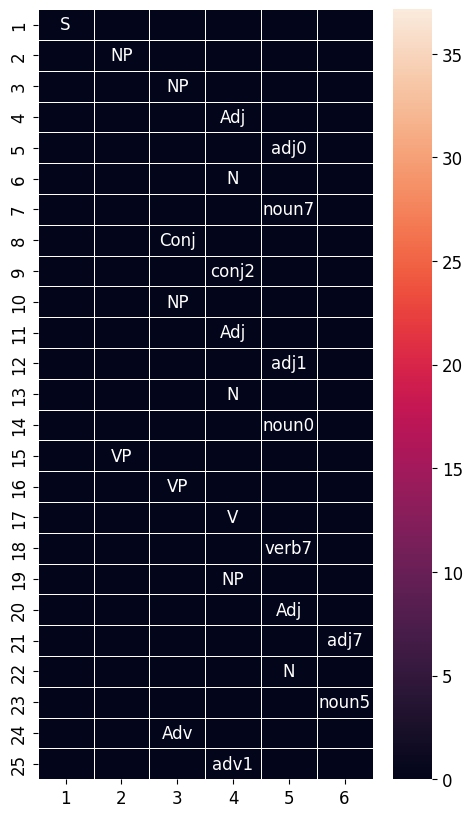

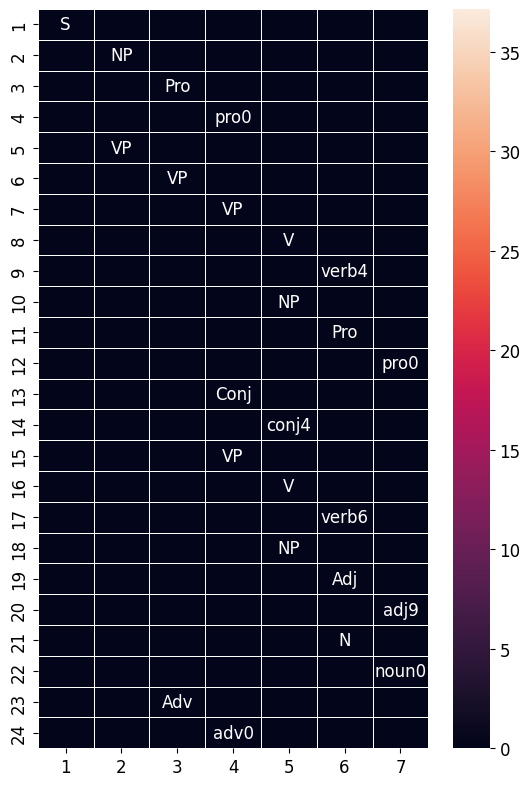

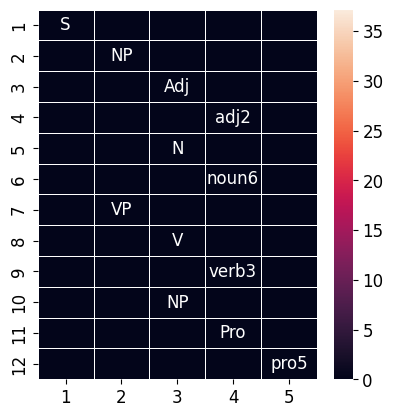

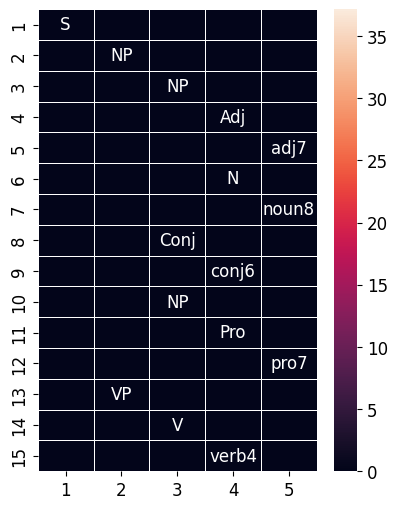

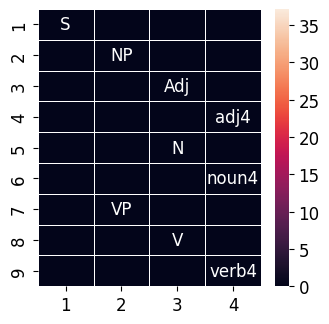

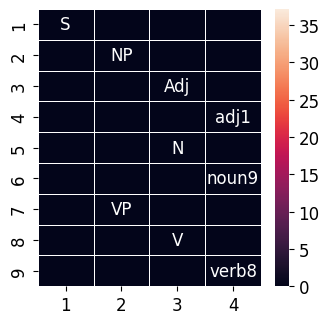

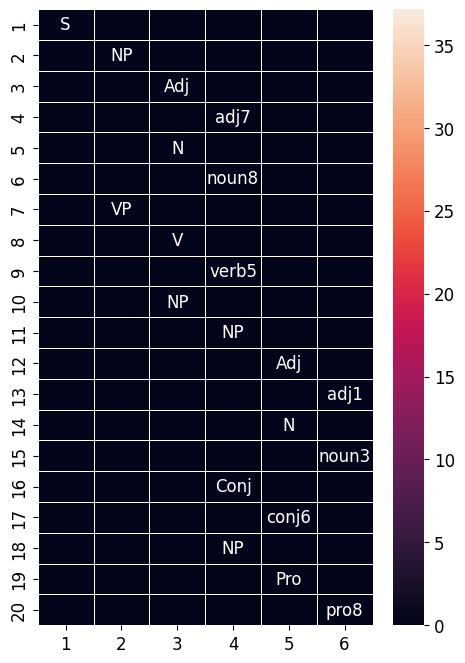

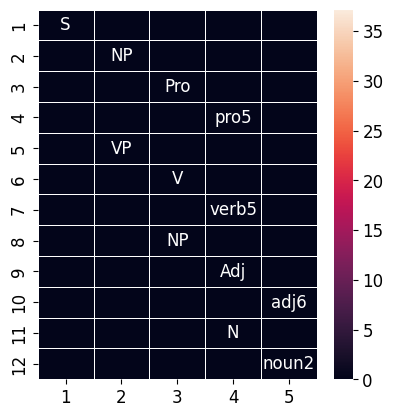

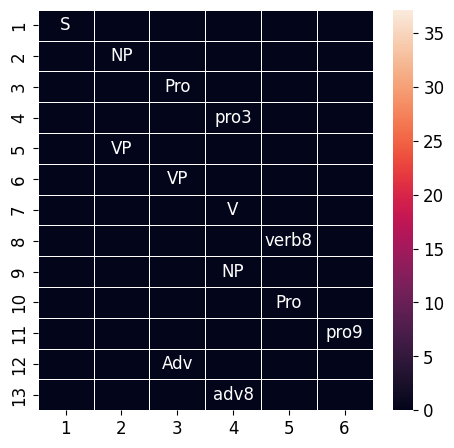

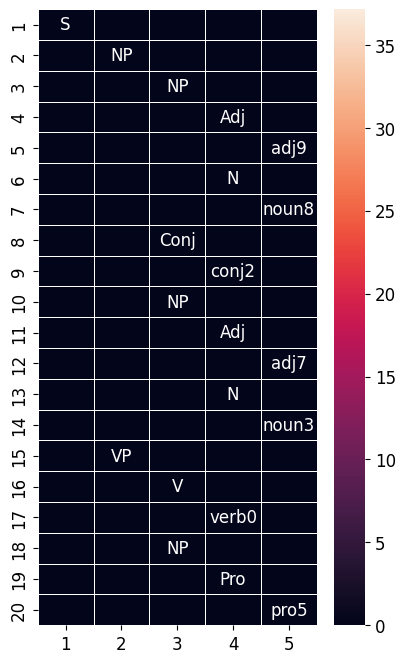

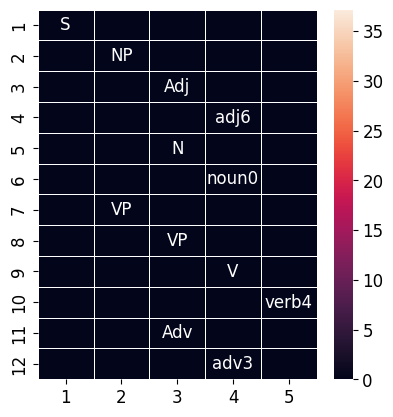

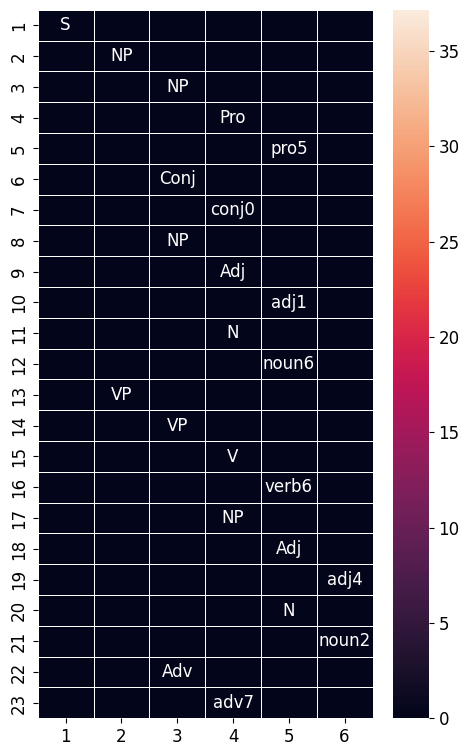

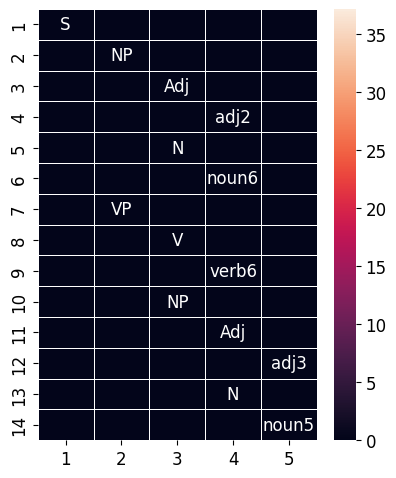

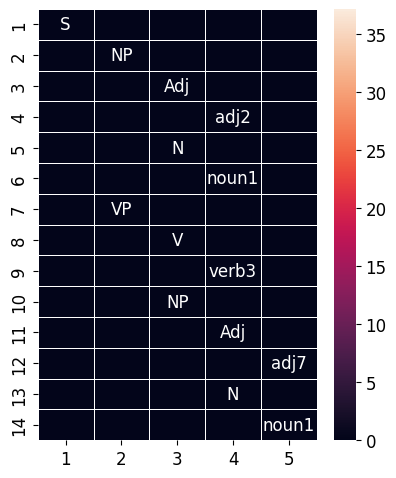

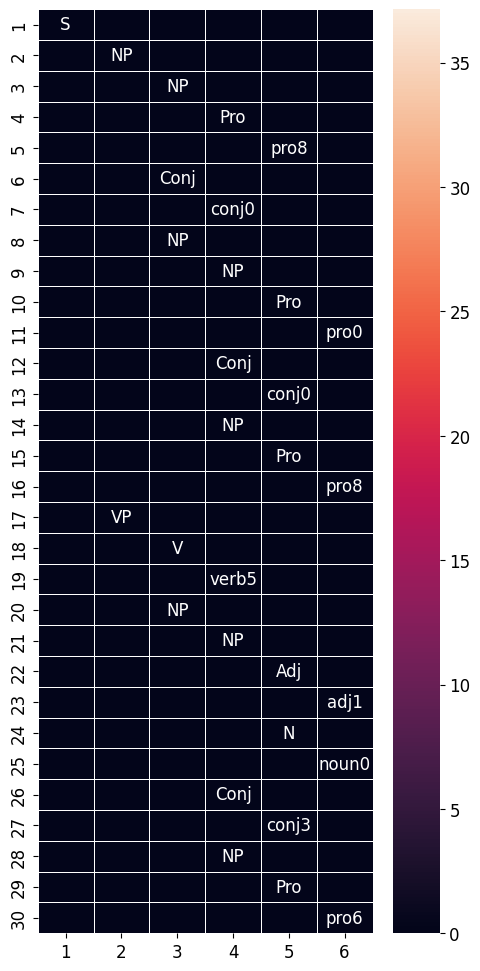

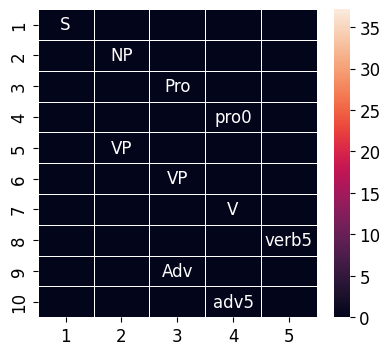

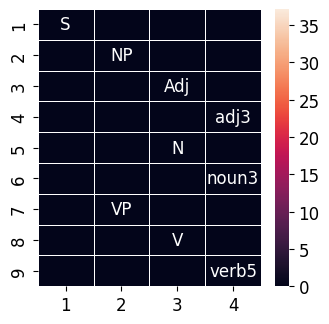

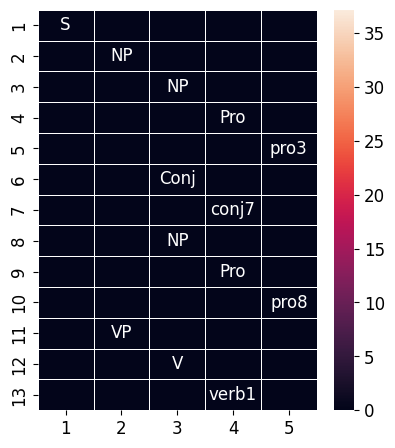

In [24]:
dead = True
while dead:
    fidx = random.randint(0, latents.size(-1))
    print(fidx)
    dead = latents[:, fidx].sum().item() == 0

vmin = latents[:, fidx].min().item()
vmax = latents[:, fidx].max().item()

for i in range(len(sequences)):
    #plot_latents_linearly(pcfg.detokenize_sentence(sequences[i]).split(), 
    #                      latents_by_sequence[i][:, fidx], vmax, vmin, heatmap=False)
    plot_latents_by_depth(pcfg.detokenize_sentence(sequences[i]).split(),
                          latents_by_sequence[i][:, fidx], pcfg, vmax, vmin)
    #plot_latents_by_pending(pcfg.detokenize_sentence(sequences[i]).split(),
    #                        latents_by_sequence[i][:, fidx], vmax, vmin)


To analyse single sequences.

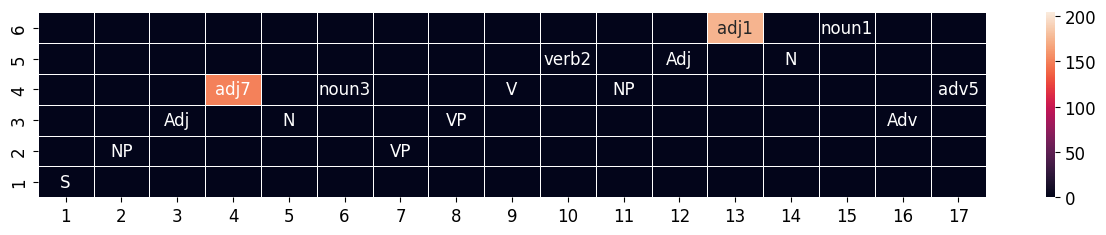

In [27]:
sample = 'adj7 noun3 verb2 adj1 noun1 adv5'

tokens = sample.split()
base_sequence = pcfg.tokenize_sentence(sample)

instr = pcfg.tokenize_sentence(dataloader.dataset.instruction_decorator.format(task_token='Task0', ops='<null>'))
sequence = torch.cat((
    torch.tensor(instr),
    torch.tensor(base_sequence),
    torch.tensor([pcfg.vocab['<eos>']])
    )).long()

activation = 0
def hook(model, input, output):
    global activation
    activation = output
handle = module.register_forward_hook(hook)
logits = model(sequence.unsqueeze(0))
handle.remove()

latents, _ = sae(activation)

token_wise_latents = latents[0, dataloader.dataset.decorator_length:-1, fidx]
#print(max(get_depths(tokens, pcfg)))

plot_latents_by_depth(tokens, token_wise_latents, pcfg, vmax, vmin)

Search for POS-based features by correlation.

In [19]:
hm = torch.zeros(latents.size(-1), 6)

for fidx in range(latents.size(-1)):
    pos_ft = [[] for _ in ['noun', 'verb', 'adj', 'adv', 'conj', 'pro']]
    activations = []
    for i in range(len(sequences)):
        activations += latents_by_sequence[i][:, fidx].tolist()
        for j, pos in enumerate(['noun', 'verb', 'adj', 'adv', 'conj', 'pro']):
            pos_ft[j] += [1 if pcfg.id_to_token_map[token][:-1] == pos else 0 for token in sequences[i]]
    
    hm[fidx] = torch.tensor([torch.corrcoef(torch.tensor([activations, pos_ft[i]]))[0, 1] for i in range(6)])

hm = hm[~torch.any(hm.isnan(), dim=1)]

In [27]:
#hm[~torch.any(hm.isnan(),dim=1)]

torch.Size([801, 6])

<Axes: >

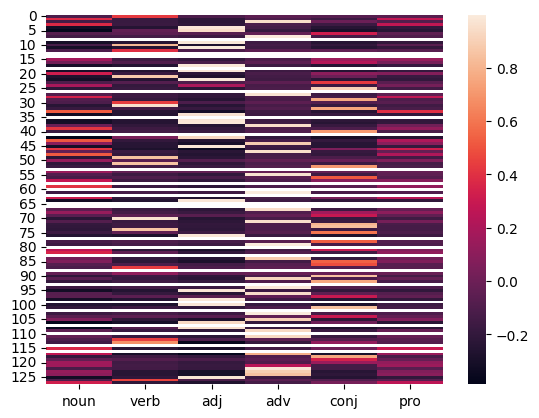

In [16]:
sns.heatmap(hm[:128, :], cmap='rocket', xticklabels=['noun', 'verb', 'adj', 'adv', 'conj', 'pro'])

We can now check the correlation between the SAE's features and our explanations.

In [11]:
def predicted_feature_204_english_63(tokens, pcfg):
    return [1 if token[:-1] == 'verb' else 0 for token in tokens]

In [17]:
def predicted_feature_695_english_63(tokens, pcfg):
    return [1 if token[:-1] in ['pro', 'noun'] else 0 for token in tokens]

In [13]:
def predicted_feature_369_english_63(tokens, pcfg):
    return [1 if token[:-1] == 'adj' else 0 for token in tokens]

In [15]:
def predicted_feature_822_english_63(tokens, pcfg):
    return [1 if token[:-1] == 'adv' else 0 for token in tokens]

In [17]:
def predicted_feature_542_english_63(tokens, pcfg):
    return [1 if token[:-1] == 'conj' else 0 for token in tokens]

In [19]:
def predicted_feature_608_english_63(tokens, pcfg):
    """All conjunctions except the first one in the VP"""
    parsed = str(next(pcfg.parser.parse(tokens))).split()[:-1]
    after_vp = 0
    tidx = -1
    pidx = 0
    feats = [0 for _ in tokens]
    while pidx < len(parsed)-1:
        p = parsed[pidx].replace('(', '').replace(')', '')

        if p == 'VP' and after_vp == 0: after_vp = 1

        if p == tokens[tidx+1]:
            tidx += 1
            if tokens[tidx][:-1] == 'conj':
                if after_vp != 1: feats[tidx] = 1
                else: after_vp = 2
        pidx += 1
    return feats

In [20]:
def predicted_feature_543_english_63(tokens, pcfg):
    """All verbs except the first one."""
    feats = [1 if token[:-1] == 'verb' else 0 for token in tokens]
    i = feats.index(1)
    feats[i] = 0
    return feats

In [14]:
def predicted_feature_721_english_67(tokens, pcfg):
    """Nouns, pronouns and conjunctions."""
    return [1 if token[:-1] in ['noun', 'pro', 'conj'] else 0 for token in tokens]

In [19]:
def predicted_feature_761_english_67(tokens, pcfg):
    """Verbs and conjunctions after the first ones in the VP."""
    first_verb_seen = False
    first_conj_seen = False
    parsed = str(next(pcfg.parser.parse(tokens))).split()[:-1]
    pidx = 0
    tidx = -1
    feats = [0 for _ in tokens]
    while pidx < len(parsed):
        p = parsed[pidx].replace('(', '').replace(')', '')
        if p == tokens[tidx+1]:
            tidx += 1
            if tokens[tidx][:-1] == 'verb' and not first_verb_seen:
                first_verb_seen = True
            if tokens[tidx][:-1] == 'conj' and first_verb_seen and not first_conj_seen:
                first_conj_seen = True
            if tokens[tidx][:-1] in ['verb', 'conj'] and first_verb_seen and first_conj_seen:
                feats[tidx] = 1
        pidx += 1
    return feats

In [1]:
def predicted_feature_844_english_67(tokens, pcfg):
    """
    Adjectives, nouns, pronouns, adverbs and subject conjunctions
    after the first conjunction.
    """
    parsed = str(next(pcfg.parser.parse(tokens))).split()[:-1]
    pidx = 0
    tidx = -1
    first_conj_seen = False
    in_subject = True
    feats = [0 for _ in tokens]
    while pidx < len(parsed):
        p = parsed[pidx].replace('(', '').replace(')', '')
        if p == 'VP': in_subject = False
        if p == tokens[tidx+1]:
            tidx += 1
            if in_subject and tokens[tidx][:-1] == 'conj' and not first_conj_seen:
                first_conj_seen = True
            if tokens[tidx][:-1] in ['adj', 'noun', 'pro', 'adv', 'conj'] and first_conj_seen:
                feats[tidx] = 1
        pidx += 1
    return feats

In [23]:
def predicted_feature_881_english_67(tokens, pcfg):
    """Conjunctions in the VP and adverbs after the third consecutive one."""
    parsed = str(next(pcfg.parser.parse(tokens))).split()[:-1]
    pidx = 0
    tidx = -1
    consecutive_adverbs = 0
    in_vp = False
    feats = [0 for _ in tokens]
    while pidx < len(parsed):
        p = parsed[pidx].replace('(', '').replace(')', '')
        if p == 'VP': in_vp = True
        if p == tokens[tidx+1]:
            tidx += 1
            if tokens[tidx][:-1] == 'adv':
                consecutive_adverbs += 1
                if consecutive_adverbs > 3:
                    feats[tidx] = 1
            else: consecutive_adverbs = 0
            if tokens[tidx][:-1] == 'conj' and in_vp:
                feats[tidx] = 1
        pidx += 1
    return feats

In [11]:
def conj(tokens, pcfg):
    return [1 if t[:-1] == 'conj' and tokens[i+1][:-1] in ['adj', 'noun']  else 0 for i, t in enumerate(tokens)]

In [12]:
#fidx = 542
#idx = 63
for fidx in range(latents.size(-1)):
    predicted_ft = []
    sae_ft = []
    depths = []
    for i in range(len(sequences)):
        tokens = pcfg.detokenize_sentence(sequences[i]).split()

        # Feature n
        predicted_ft += [f for j, f in enumerate(conj(tokens, pcfg))] #eval(f'predicted_feature_{fidx}_english_{idx}')(tokens, pcfg)

        # SAE Activation
        sae_ft += [l for j, l in enumerate(latents_by_sequence[i][:, fidx].tolist())]

        #depths += [ceil(d/2)-2 for d in get_depths(tokens, pcfg)]


    ρ = torch.corrcoef(torch.tensor([predicted_ft, sae_ft]))[0, 1].item()
    if not math.isnan(ρ): print(fidx, ρ)

# For multi-class/continuous features
# Option 1: Scatterplot with colour-coded depths
#colours = matplotlib.cm.Reds([d/max(depths) for d in depths])
#plt.scatter(predicted_ft, sae_ft, c=colours)
#plt.xlabel('Predicted')
#plt.ylabel('Activation')

# # Option 2: Heatmap of average activation per depth-feature pair
# acts = [[[] for _ in range(max(predicted_ft)+1)] for _ in range(max(depths)+1)]
# for i, f in enumerate(predicted_ft):
#     acts[max(depths)-depths[i]][f].append(sae_ft[i])
# means = torch.tensor([[torch.tensor(acts[d][f]).mean().item() for f in range(max(predicted_ft)+1)] for d in range(max(depths)+1)])
# plt.figure(figsize=(10, 7))
# sns.heatmap(means, annot=True, fmt='.2f', linewidths=.5, cmap='Reds', xticklabels=range(max(predicted_ft)+1), yticklabels=range(max(depths), -1, -1))
# plt.xlabel('Count')
# plt.ylabel('Depth')

# For binary features
#plt.violinplot([[sae_ft[i] for i, f in enumerate(predicted_ft) if f == x]
#                for x in range(min(predicted_ft), max(predicted_ft)+1)], positions=range(min(predicted_ft), max(predicted_ft)+1))

#plt.show()

0 0.05884844437241554
1 0.08665887266397476
3 0.029029324650764465
4 0.08598688244819641
5 0.032683830708265305
6 0.08620959520339966
9 0.14525027573108673
13 0.06475132703781128
15 -0.5584472417831421
18 0.08580843359231949
19 0.046892378479242325
20 0.13525556027889252
21 -0.4354304075241089
23 0.037597641348838806
25 0.14513853192329407
26 -0.03839315474033356
28 -0.627647340297699
30 0.06337819993495941
32 0.13306470215320587
33 0.04517870768904686
35 0.1294022649526596
37 0.11702235788106918
40 -0.34589019417762756
41 0.061292171478271484
47 0.11655821651220322
48 0.009529721923172474
50 0.11051387339830399
51 0.06657300144433975
52 0.1162431389093399
56 0.1570599526166916
58 0.16747288405895233
59 -0.2530076205730438
61 0.03005198948085308
62 -0.009562232531607151
64 0.11544673889875412
67 0.12068704515695572
70 0.14210085570812225
71 0.17383334040641785
72 0.03897809609770775
74 0.16926288604736328
75 -0.6170054078102112
77 0.08667165786027908
79 -0.6315550804138184
85 0.0444598

### Feature Visualization
We run 2-D UMAP on the feature directions.

/opt/homebrew/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/opt/homebrew/lib/python3.11/site-packages/umap/plot.py:449: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(points[:, 0], points[:, 1], s=point_size, c=color)


<Axes: >

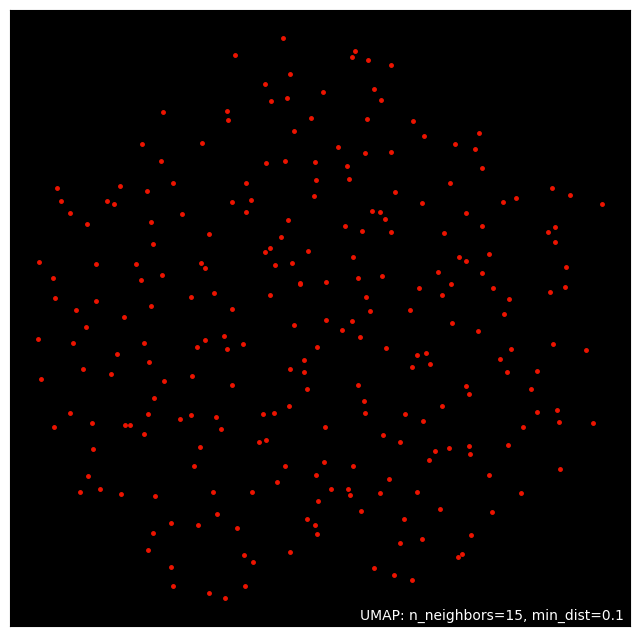

In [305]:
directions1 = get_sae(489).decoder.weight.data.detach().transpose(0, 1) # [128, 128]
#directions2 = get_sae(111).decoder.weight.data.detach().transpose(0, 1) # [256, 128]
#directions4 = get_sae(186).decoder.weight.data.detach().transpose(0, 1) # [512, 128]
#directions8 = get_sae(106).decoder.weight.data.detach().transpose(0, 1) # [1024, 128]

#mapper = um.UMAP(random_state=42).fit(torch.cat([directions1, directions2, directions4, directions8], dim=0))
#umap.plot.points(mapper, labels=torch.tensor([128]*128 + [256]*256 + [512]*512 + [1024]*1024), theme='fire')
mapper = um.UMAP(random_state=42).fit(directions1)
umap.plot.points(mapper, theme='fire')

We run UMAP on the features themselves also.

/opt/homebrew/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


<Axes: >

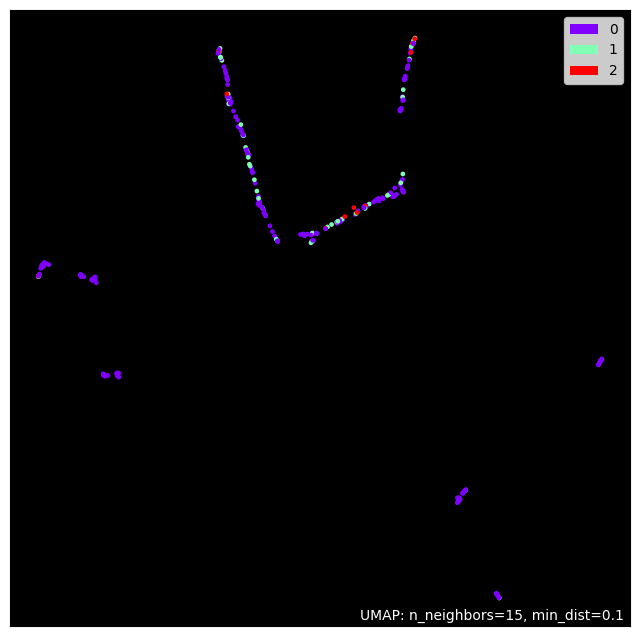

In [312]:
features, sequences = get_latents_and_sequences(get_sae(489), num_batches=10)

mapper = um.UMAP(random_state=42).fit(features)
# According to token identity
#umap.plot.points(mapper, labels=torch.tensor([0 if s in range(10) 
#                                         else 1 if s in range(10, 13)
#                                         else 2 if s in range(13, 16)
#                                         else 3
#                                         for _ in sequences for s in _]), theme='fire')
# According to token position
#umap.plot.points(mapper, labels=torch.tensor([s // 10 for _ in sequences for s in range(len(_))]), theme='fire')